# Variability due to dynamical or property change?
redid equation to include cross term

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

1. [Functions](##-Functions)
2. [Upwelling](##-Upwelling)
3. [Downwelling](##-Downwelling)
4. [Test with observations](##-Test-with-Observations)

## Functions

In [2]:
########
# MATH #
########

def decomp(data,base):
    # slight variation in euation from other attribution file
    # not dividing by transport - so looking at flux of a property instead of just mean property change
    d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
        'saltP':np.zeros(8),'saltQ':np.zeros(8),'saltX':np.zeros(8),'saltSUM':np.zeros(8),
        'tempP':np.zeros(8),'tempQ':np.zeros(8),'tempX':np.zeros(8),'tempSUM':np.zeros(8),
        'DOP':np.zeros(8),'DOQ':np.zeros(8),'DOX':np.zeros(8),'DOSUM':np.zeros(8),
        'TAP':np.zeros(8),'TAQ':np.zeros(8),'TAX':np.zeros(8),'TASUM':np.zeros(8),
        'NO3P':np.zeros(8),'NO3Q':np.zeros(8),'NO3X':np.zeros(8),'NO3SUM':np.zeros(8),
        'DICP':np.zeros(8),'DICQ':np.zeros(8),'DICX':np.zeros(8),'DICSUM':np.zeros(8)}
    df = pd.DataFrame(d)

    # salt
    df['saltP'] = (data.salt[1:] - base.salt[1:])*(base.transport[1:])
    df['saltQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.salt[1:]
    df['saltX'] = (data.salt[1:]-base.salt[1:])*(data.transport[1:]-base.transport[1:])
    df['saltSUM'] = df.saltP + df.saltQ

    # temp
    df['tempP'] = (data.temp[1:] - base.temp[1:])*(base.transport[1:])
    df['tempQ'] = ((data.transport[1:])  - (base.transport[1:]))*base.temp[1:]
    df['tempX'] = (data.temp[1:]-base.temp[1:])*(data.transport[1:]-base.transport[1:])
    df['tempSUM'] = df.tempP + df.tempQ

    # do
    df['DOP'] = (data.DO[1:] - base.DO[1:])*(base.transport[1:])
    df['DOQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.DO[1:]
    df['DOX'] = (data.DO[1:]-base.DO[1:])*(data.transport[1:]-base.transport[1:])
    df['DOSUM'] = df.DOP + df.DOQ

    # ta
    df['TAP'] = (data.TA[1:] - base.TA[1:])*(base.transport[1:])
    df['TAQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.TA[1:]
    df['TAX'] = (data.TA[1:]-base.TA[1:])*(data.transport[1:]-base.transport[1:])
    df['TASUM'] = df.TAP + df.TAQ

    # dic
    df['DICP'] = (data.DIC[1:] - base.DIC[1:])*(base.transport[1:])
    df['DICQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.DIC[1:]
    df['DICX'] = (data.DIC[1:]-base.DIC[1:])*(data.transport[1:]-base.transport[1:])
    df['DICSUM'] = df.DICP + df.DICQ

    # no3
    df['NO3P'] = (data.NO3[1:] - base.NO3[1:])*(base.transport[1:])
    df['NO3Q'] = ((data.transport[1:]) - (base.transport[1:]))*base.NO3[1:]
    df['NO3X'] = (data.NO3[1:]-base.NO3[1:])*(data.transport[1:]-base.transport[1:])
    df['NO3SUM'] = df.NO3P + df.NO3Q

    # TA-DIC
    df['TADICP'] = (data['TA-DIC'][1:] - base['TA-DIC'][1:])*(base.transport[1:])
    df['TADICQ'] = ((data.transport[1:]) - (base.transport[1:]))*base['TA-DIC'][1:]
    df['TADICX'] = (data['TA-DIC'][1:]-base['TA-DIC'][1:])*(data.transport[1:]-base.transport[1:])
    df['TADICSUM'] = df.TADICP + df.TADICQ

    return df



def means_combo(UPs_t, UPdo_no3, UPta_dic,DWs_t, DWdo_no3, DWta_dic,):
    # make dictionary of mean transport and tracer concentrations of each WM and of JdF inflow

    # set up dictionary
    # for each variable, saved in the order total -> loop -> fresh -> south -> cuc -> off_d -> off_s -> north
    d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
        'transport':np.zeros(8),'salt':np.zeros(8),'temp':np.zeros(8),
         'DO':np.zeros(8),'NO3':np.zeros(8),'TA':np.zeros(8),'DIC':np.zeros(8)}
    df = pd.DataFrame(d)

    # hours over which data was integrated
    start = 2401
    UPlength =(np.max(UPs_t.init_t)-start+1) 
    DWlength =(np.max(DWs_t.init_t)-start+1) 

    # boundary definitions
    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4

    saltdiv = 32
    sdiv = 33.5

    
    # total
    up = UPs_t
    dw = DWs_t
    upbool = ((abs(up.init_t-up.final_t) > 24) & ~np.isnan(up.final_section)) # total.. but not including tidal pumping or lost particles
    dwbool = ((abs(dw.init_t-dw.final_t) > 24) & ~np.isnan(dw.final_section))
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[0,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[0,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[0,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[0,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[0,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[0,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[0,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # loop
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_loo) & (abs(up.init_t-up.final_t) > 24)
    dwbool = (dw.final_section==bdy_loo) & (abs(dw.init_t-dw.final_t) > 24)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[7,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[7,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[7,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[7,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[7,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[7,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[7,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # fresh
    up = UPs_t
    dw = DWs_t
    upbool = ((up.final_section==bdy_sou) & (up.final_salt < saltdiv))
    dwbool = ((dw.final_section==bdy_sou) & (dw.final_salt < saltdiv))
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[6,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[6,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[6,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[6,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[6,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[6,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[6,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # south
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_sou) & (up.final_salt >= saltdiv) & (up.final_salt < sdiv)
    dwbool = (dw.final_section==bdy_sou) & (dw.final_salt >= saltdiv) & (dw.final_salt < sdiv)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[5,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[5,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[5,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[5,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[5,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[5,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[5,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # cuc
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_sou) & (up.final_salt >= sdiv)
    dwbool = (dw.final_section==bdy_sou) & (dw.final_salt >= sdiv)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[1,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[1,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[1,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[1,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[1,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[1,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[1,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # off_d
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_off) & (up.final_depth > 120)
    dwbool = (dw.final_section==bdy_off) & (dw.final_depth > 120)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[2,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[2,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[2,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[2,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[2,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[2,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[2,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # off_s
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_off) & (up.final_depth <=120)
    dwbool = (dw.final_section==bdy_off) & (dw.final_depth <=120)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[3,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[3,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[3,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[3,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[3,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[3,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[3,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # north
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_nor)
    dwbool = (dw.final_section==bdy_nor)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[4,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[4,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[4,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[4,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[4,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[4,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[4,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    return df
    

In [3]:
############
# PLOTTING #
############

def stacked_bar(df, property,ax,ax2):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)

    # Plotting
    # fig = plt.figure(constrained_layout=True, figsize=[8,6])
    # gs = GridSpec(1, 5, figure=fig)
    # ax = fig.add_subplot(gs[0, :4])
    # ax2 = fig.add_subplot(gs[0, 4])

    # Assign colors to each section
    # pivot tables come out in order cuc -> fresh -> north -> off_d -> off_s -> south
    colors = ['darkviolet','magenta', 'mediumseagreen','midnightblue','deepskyblue','red']

    # Plot normalized saltP values (left side)
    left_cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(pivotP.columns):
        bars = ax.barh(pivotP.index, -pivotP[section], left=-left_cum_values, color=colors[i % len(colors)], label=section)
        left_cum_values += pivotP[section]

    # Plot normalized saltQ values (right side)
    right_cum_values = np.zeros(len(pivotQ))
    for i, section in enumerate(pivotQ.columns):
        bars = ax.barh(pivotQ.index, pivotQ[section], left=right_cum_values, color=colors[i % len(colors)])
        right_cum_values += pivotQ[section]

    # Customize plot
    ax.axvline(0, color='grey', linewidth=2)
    # ax.set_xlabel('Normalized Absolute Values')
    title = property
    ax.set_title(title)
    # ax.set_xlim(-0.1,1.1)
    ax.set_xticks([-1,-0.5,0,0.5,1])
    ax.set_xlim([-1,1])
    ax.invert_yaxis()
    ax.set_yticks(list(set(df.year)))
    ax.set_yticklabels(list(set(df.year)))

    # Ensure both axes share the same y-axis
    ax2.sharey(ax)
    # Hide y-tick labels on ax2
    ax2.tick_params(axis='y', which='both', labelleft=False)

    plt.tight_layout()

def three_bar(df, property,ax):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()
    df['absX'] = df[df.columns[4]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ', 'absX']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']
    df['normX'] = df['absX'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ', 'normX']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)
    pivotX = agg_df.pivot(index='year', columns='section', values='normX').fillna(0)

    colors = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
    sections = ['cuc','off_d','off_s','north','south','fresh']
    # for i, section in enumerate(pivotP.columns):
    cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(sections):
            ax.bar(pivotQ.index-0.3, pivotQ[section], bottom=cum_values, color=colors[i % len(colors)], edgecolor=colors[i % len(colors)], hatch='///', alpha=0.8, width=0.29, label=section)
            cum_values += pivotQ[section]

    cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(sections):
            ax.bar(pivotP.index, pivotP[section], bottom=cum_values, color=colors[i % len(colors)], width=0.29, label=section)
            cum_values += pivotP[section]

    cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(sections):
            ax.bar(pivotX.index+0.3, pivotX[section], bottom=cum_values, color=colors[i % len(colors)], alpha=0.6, width=0.29, label=section)
            cum_values += pivotX[section]

    # Customize plot
    ax.set_title(property)
    ax.set_xlim([np.min(pivotQ.index)-1,np.max(pivotQ.index)+1])
    ax.set_xticks(pivotQ.index)
    ax.set_yticks([0,0.5,1])
    ax.set_xticklabels([])
    ax.set_ylim([0,1])

def combined_stacked_bar(df, property, ax, ax2):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)

    # Assign colors to each section
    # pivot tables come out in order cuc -> fresh -> north -> off_d -> off_s -> south
    colors = ['darkviolet','magenta', 'mediumseagreen','midnightblue','deepskyblue','red']

    # Plot normalized saltP values (left side)
    left_cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(pivotP.columns):
        bars = ax.barh(pivotP.index, -pivotP[section], left=-left_cum_values, color=colors[i % len(colors)], label=section)
        left_cum_values += pivotP[section]

    # Plot normalized saltQ values (right side)
    right_cum_values = np.zeros(len(pivotQ))
    for i, section in enumerate(pivotQ.columns):
        bars = ax.barh(pivotQ.index, pivotQ[section], left=right_cum_values, color=colors[i % len(colors)])
        right_cum_values += pivotQ[section]

    # Customize plot
    ax.axvline(0, color='grey', linewidth=2)
    # ax.set_xlabel('Normalized Absolute Values')
    title = property
    ax.set_title(title)
    ax.set_xlim([-1,1])
    ax.set_xticks([-1,-0.5,0,0.5,1])
    ax.set_xticklabels([])
    ax.invert_yaxis()
    ax.set_yticks(list(set(df.year)))
    ax.set_yticklabels(list(set(df.year)),fontsize=8)

    
    if str(type(ax2)) == "<class 'matplotlib.axes._axes.Axes'>":
        # Ensure both axes share the same y-axis
        ax2.sharey(ax)
        # Hide y-tick labels on ax2
        ax2.tick_params(axis='y', which='both', labelleft=False)

    plt.tight_layout()

## Upwelling

In [4]:
up13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2013.csv')
up14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2014.csv')
up15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2015.csv')
up16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2016.csv')
up17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2017.csv')
up18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2018.csv')
up19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2019.csv')
up20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2020.csv')
up21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2021.csv')
up22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2022.csv')
up23 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2023.csv')


In [5]:
# add [TA-DIC] column
files = [up13,up14,up15,up16,up17,up18,up19,up20,up21,up22,up23]

for file in files:
    file['TA-DIC'] = file.TA - file.DIC

In [6]:
lup = [219, 161, 144, 158, 156,128,193, 244,189, 117,136] 
# number of days in each upwelling period

In [7]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([up13.transport*lup[0],up14.transport*lup[1],up15.transport*lup[2],up16.transport*lup[3],up17.transport*lup[4],
                          up18.transport*lup[5],up19.transport*lup[6], up20.transport*lup[-4],up21.transport*lup[-3],
                          up22.transport*lup[-2],up23.transport*lup[-1]],axis=0),
     'salt':np.mean([up13.salt,up14.salt,up15.salt,up16.salt,up17.salt,up18.salt,up19.salt,up20.salt,up21.salt,up22.salt,up23.salt],axis=0),
     'temp':np.mean([up13.temp,up14.temp,up15.temp,up16.temp,up17.temp,up18.temp,up19.temp,up20.temp,up21.temp,up22.temp,up23.temp],axis=0),
     'DO':np.mean([up13.DO,up14.DO,up15.DO,up16.DO,up17.DO,up18.DO,up19.DO,up20.DO,up21.DO,up22.DO,up23.DO],axis=0),
     'NO3':np.mean([up13.NO3,up14.NO3,up15.NO3,up16.NO3,up17.NO3,up18.NO3,up19.NO3,up20.NO3,up21.NO3,up22.NO3,up23.NO3],axis=0),
     'TA':np.mean([up13.TA,up14.TA,up15.TA,up16.TA,up17.TA,up18.TA,up19.TA,up20.TA,up21.TA,up22.TA,up23.TA],axis=0),
     'DIC':np.mean([up13.DIC,up14.DIC,up15.DIC,up16.DIC,up17.DIC,up18.DIC,up19.DIC,up20.DIC,up21.DIC,up22.DIC,up23.DIC],axis=0),
     'TA-DIC':np.mean([up13['TA-DIC'],up14['TA-DIC'],up15['TA-DIC'],up16['TA-DIC'],up17['TA-DIC'],up18['TA-DIC'],up19['TA-DIC'],up20['TA-DIC'],up21['TA-DIC'],up22['TA-DIC'],up23['TA-DIC']],axis=0)}
up_b = pd.DataFrame(d)

up_b

,section,transport,salt,temp,DO,NO3,TA,DIC,TA-DIC
0,salish,2.961979e+07,33.465078,7.062831,87.293498,32.593670,2298.287658,2293.616203,4.671455
1,cuc,7.057995e+06,33.901923,6.256904,63.735533,37.111555,2325.158312,2324.556653,0.601660
2,off_d,6.668666e+06,33.752022,6.602244,89.420496,33.718431,2313.645113,2296.921804,16.723309
3,off_s,1.294489e+06,32.886136,8.420147,214.708145,16.526262,2269.354926,2159.713637,109.641289
4,north,5.700911e+06,33.237666,7.537585,153.192275,24.248263,2285.687486,2224.257809,61.429677
5,south,1.023964e+06,32.966940,8.872386,199.978629,19.185039,2275.038024,2179.263162,95.774863
6,fresh,2.752108e+05,29.673011,10.795049,305.075074,5.717069,2147.016763,1959.825667,187.191096
7,loop,7.598554e+06,32.082289,8.788532,159.749810,28.433345,2233.388080,2193.911539,39.476541


In [8]:
up13.transport = up13.transport*lup[0]
up14.transport = up14.transport*lup[1]
up15.transport = up15.transport*lup[2]
up16.transport = up16.transport*lup[3]
up17.transport = up17.transport*lup[4]
up18.transport = up18.transport*lup[5]
up19.transport = up19.transport*lup[6]
up20.transport = up20.transport*lup[-4]
up21.transport = up21.transport*lup[-3]
up22.transport = up22.transport*lup[-2]
up23.transport = up23.transport*lup[-1]


In [9]:
# math!
math_up13 = decomp(up13,up_b)[1:]
math_up14 = decomp(up14,up_b)[1:]
math_up15 = decomp(up15,up_b)[1:]
math_up16 = decomp(up16,up_b)[1:]
math_up17 = decomp(up17,up_b)[1:]
math_up18 = decomp(up18,up_b)[1:]
math_up19 = decomp(up19,up_b)[1:]
math_up20 = decomp(up20,up_b)[1:]
math_up21 = decomp(up21,up_b)[1:]
math_up22 = decomp(up22,up_b)[1:]
math_up23 = decomp(up23,up_b)[1:]

# add year 
math_up13['year'] = 2013
math_up14['year'] = 2014
math_up15['year'] = 2015
math_up16['year'] = 2016
math_up17['year'] = 2017
math_up18['year'] = 2018
math_up19['year'] = 2019
math_up20['year'] = 2020
math_up21['year'] = 2021
math_up22['year'] = 2022
math_up23['year'] = 2023

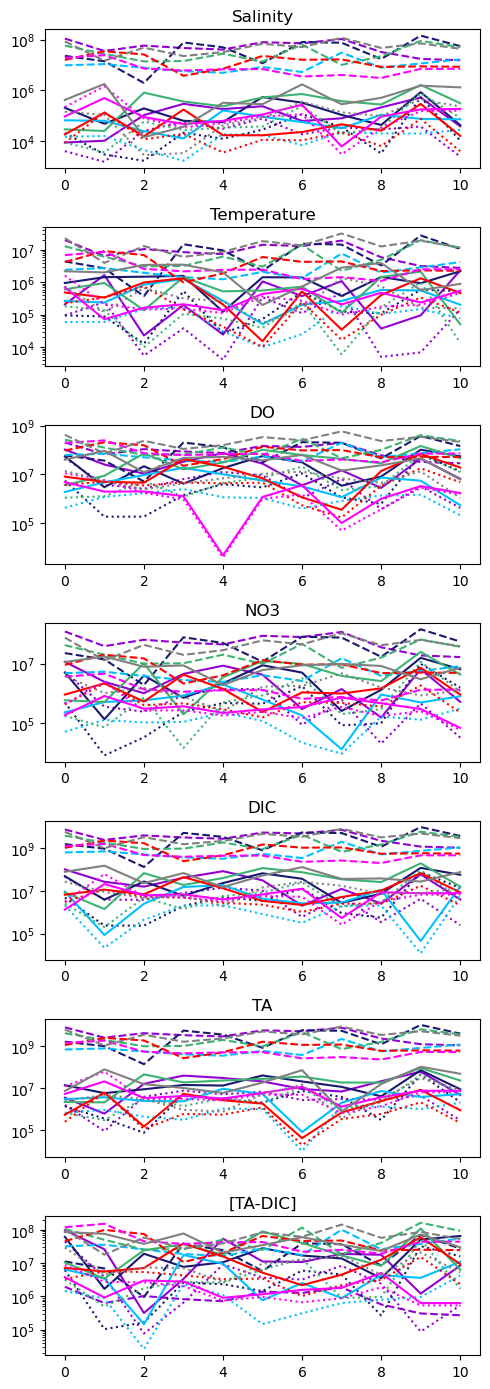

In [10]:
# plot of the magnitude of the terms over time in each water mass and tracer
maths = [math_up13, math_up14, math_up15, math_up16, math_up17, math_up18, math_up19, math_up20, math_up21, math_up22, math_up23]
regions = ['cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta','grey']

fig, ax = plt.subplots(7,1,figsize=(5,14))

for i in range(len(math_up13.section)):
    P = np.abs([math.saltP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.saltQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.saltX[math.section==regions[i]].values for math in maths])
    ax[0].plot(P,color=colours[i])
    ax[0].plot(Q,color=colours[i],ls='dashed')
    ax[0].plot(X,color=colours[i],ls='dotted')
    ax[0].set_yscale('log')
    ax[0].set_title('Salinity')


    P = np.abs([math.tempP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.tempQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.tempX[math.section==regions[i]].values for math in maths])
    ax[1].plot(P,color=colours[i])
    ax[1].plot(Q,color=colours[i],ls='dashed')
    ax[1].plot(X,color=colours[i],ls='dotted')
    ax[1].set_yscale('log')
    ax[1].set_title('Temperature')


    P = np.abs([math.DOP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.DOQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.DOX[math.section==regions[i]].values for math in maths])
    ax[2].plot(P,color=colours[i])
    ax[2].plot(Q,color=colours[i],ls='dashed')
    ax[2].plot(X,color=colours[i],ls='dotted')
    ax[2].set_yscale('log')
    ax[2].set_title('DO')


    P = np.abs([math.NO3P[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.NO3Q[math.section==regions[i]].values for math in maths])
    X = np.abs([math.NO3X[math.section==regions[i]].values for math in maths])
    ax[3].plot(P,color=colours[i])
    ax[3].plot(Q,color=colours[i],ls='dashed')
    ax[3].plot(X,color=colours[i],ls='dotted')
    ax[3].set_yscale('log')
    ax[3].set_title('NO3')


    P = np.abs([math.DICP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.DICQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.DICX[math.section==regions[i]].values for math in maths])
    ax[4].plot(P,color=colours[i])
    ax[4].plot(Q,color=colours[i],ls='dashed')
    ax[4].plot(X,color=colours[i],ls='dotted')
    ax[4].set_yscale('log')
    ax[4].set_title('DIC')


    P = np.abs([math.TAP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.TAQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.TAX[math.section==regions[i]].values for math in maths])
    ax[5].plot(P,color=colours[i])
    ax[5].plot(Q,color=colours[i],ls='dashed')
    ax[5].plot(X,color=colours[i],ls='dotted')
    ax[5].set_yscale('log')
    ax[5].set_title('TA')


    P = np.abs([math.TADICP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.TADICQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.TADICX[math.section==regions[i]].values for math in maths])
    ax[6].plot(P,color=colours[i])
    ax[6].plot(Q,color=colours[i],ls='dashed')
    ax[6].plot(X,color=colours[i],ls='dotted')
    ax[6].set_yscale('log')
    ax[6].set_title('[TA-DIC]')

plt.tight_layout()

/tmp/ipykernel_197590/819159033.py:161: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


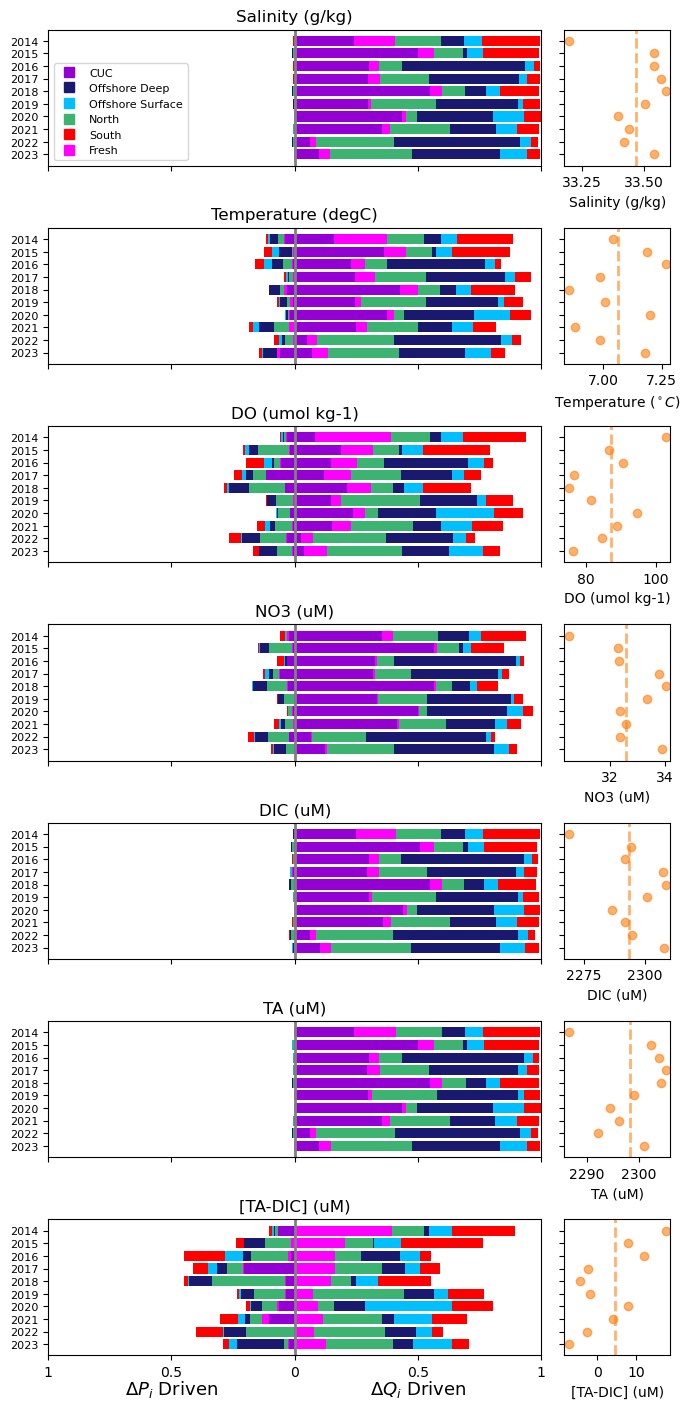

In [11]:
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[7,2*7])
gs = GridSpec(7, 5, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])
ax3 = fig.add_subplot(gs[1, :4])
ax4 = fig.add_subplot(gs[1, 4])
ax5 = fig.add_subplot(gs[2, :4])
ax6 = fig.add_subplot(gs[2, 4])
ax7 = fig.add_subplot(gs[3, :4])
ax8 = fig.add_subplot(gs[3, 4])
ax9 = fig.add_subplot(gs[4, :4])
ax10 = fig.add_subplot(gs[4, 4])
ax11 = fig.add_subplot(gs[5, :4])
ax12 = fig.add_subplot(gs[5, 4])
ax13 = fig.add_subplot(gs[6, :4])
ax14 = fig.add_subplot(gs[6, 4])

# SALINITY
df = pd.concat([math_up14[['year','section','saltP','saltQ']][:-1],math_up15[['year','section','saltP','saltQ']][:-1],
    math_up16[['year','section','saltP','saltQ']][:-1],math_up17[['year','section','saltP','saltQ']][:-1],
    math_up18[['year','section','saltP','saltQ']][:-1],math_up19[['year','section','saltP','saltQ']][:-1],
    math_up20[['year','section','saltP','saltQ']][:-1],math_up21[['year','section','saltP','saltQ']][:-1],
    math_up22[['year','section','saltP','saltQ']][:-1],math_up23[['year','section','saltP','saltQ']][:-1]])
combined_stacked_bar(df,'Salinity (g/kg)',ax1,ax2)

# mean property inflow to JdF
ax2.scatter([up14.salt[0],up15.salt[0],up16.salt[0],up17.salt[0],up18.salt[0],up19.salt[0],up20.salt[0],up21.salt[0],up22.salt[0],up23.salt[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:orange')
ax2.axvline(up_b.salt[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax2.set_xlabel('Salinity (g/kg)',fontsize=10)

# TEMPERATURE
df = pd.concat([math_up14[['year','section','tempP','tempQ']][:-1],math_up15[['year','section','tempP','tempQ']][:-1],
    math_up16[['year','section','tempP','tempQ']][:-1],math_up17[['year','section','tempP','tempQ']][:-1],
    math_up18[['year','section','tempP','tempQ']][:-1],math_up19[['year','section','tempP','tempQ']][:-1],
    math_up20[['year','section','tempP','tempQ']][:-1],math_up21[['year','section','tempP','tempQ']][:-1],
    math_up22[['year','section','tempP','tempQ']][:-1],math_up23[['year','section','tempP','tempQ']][:-1]])
combined_stacked_bar(df,'Temperature (degC)',ax3,ax4)

# mean property inflow to JdF
ax4.scatter([up14.temp[0],up15.temp[0],up16.temp[0],up17.temp[0],up18.temp[0],up19.temp[0],up20.temp[0],up21.temp[0],up22.temp[0],up23.temp[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:orange')
ax4.axvline(up_b.temp[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax4.set_xlabel('Temperature ($^\circ C$)',fontsize=10)

# DO
df = pd.concat([math_up14[['year','section','DOP','DOQ']][:-1],math_up15[['year','section','DOP','DOQ']][:-1],
    math_up16[['year','section','DOP','DOQ']][:-1],math_up17[['year','section','DOP','DOQ']][:-1],
    math_up18[['year','section','DOP','DOQ']][:-1],math_up19[['year','section','DOP','DOQ']][:-1],
    math_up20[['year','section','DOP','DOQ']][:-1],math_up21[['year','section','DOP','DOQ']][:-1],
    math_up22[['year','section','DOP','DOQ']][:-1],math_up23[['year','section','DOP','DOQ']][:-1]])
combined_stacked_bar(df,'DO (umol kg-1)',ax5,ax6)

# mean property inflow to JdF
ax6.scatter([up14.DO[0],up15.DO[0],up16.DO[0],up17.DO[0],up18.DO[0],up19.DO[0],up20.DO[0],up21.DO[0],up22.DO[0],up23.DO[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:orange')
ax6.axvline(up_b.DO[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax6.set_xlabel('DO (umol kg-1)',fontsize=10)

# NO3
df = pd.concat([math_up14[['year','section','NO3P','NO3Q']][:-1],math_up15[['year','section','NO3P','NO3Q']][:-1],
    math_up16[['year','section','NO3P','NO3Q']][:-1],math_up17[['year','section','NO3P','NO3Q']][:-1],
    math_up18[['year','section','NO3P','NO3Q']][:-1],math_up19[['year','section','NO3P','NO3Q']][:-1],
    math_up20[['year','section','NO3P','NO3Q']][:-1],math_up21[['year','section','NO3P','NO3Q']][:-1],
    math_up22[['year','section','NO3P','NO3Q']][:-1],math_up23[['year','section','NO3P','NO3Q']][:-1],])
combined_stacked_bar(df,'NO3 (uM)',ax7,ax8)

# mean property inflow to JdF
ax8.scatter([up14.NO3[0],up15.NO3[0],up16.NO3[0],up17.NO3[0],up18.NO3[0],up19.NO3[0],up20.NO3[0],up21.NO3[0],up22.NO3[0],up23.NO3[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:orange')
ax8.axvline(up_b.NO3[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax8.set_xlabel('NO3 (uM)',fontsize=10)

# DIC
df = pd.concat([math_up14[['year','section','DICP','DICQ']][:-1],math_up15[['year','section','DICP','DICQ']][:-1],
    math_up16[['year','section','DICP','DICQ']][:-1],math_up17[['year','section','DICP','DICQ']][:-1],
    math_up18[['year','section','DICP','DICQ']][:-1],math_up19[['year','section','DICP','DICQ']][:-1],
    math_up20[['year','section','DICP','DICQ']][:-1],math_up21[['year','section','DICP','DICQ']][:-1],
    math_up22[['year','section','DICP','DICQ']][:-1],math_up23[['year','section','DICP','DICQ']][:-1],])
combined_stacked_bar(df,'DIC (uM)',ax9,ax10)

# mean property inflow to JdF
ax10.scatter([up14.DIC[0],up15.DIC[0],up16.DIC[0],up17.DIC[0],up18.DIC[0],up19.DIC[0],up20.DIC[0],up21.DIC[0],up22.DIC[0],up23.DIC[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:orange')
ax10.axvline(up_b.DIC[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax10.set_xlabel('DIC (uM)',fontsize=10)

# TA
df = pd.concat([math_up14[['year','section','TAP','TAQ']][:-1],math_up15[['year','section','TAP','TAQ']][:-1],
    math_up16[['year','section','TAP','TAQ']][:-1],math_up17[['year','section','TAP','TAQ']][:-1],
    math_up18[['year','section','TAP','TAQ']][:-1],math_up19[['year','section','TAP','TAQ']][:-1],
    math_up20[['year','section','TAP','TAQ']][:-1],math_up21[['year','section','TAP','TAQ']][:-1],
    math_up22[['year','section','TAP','TAQ']][:-1],math_up23[['year','section','TAP','TAQ']][:-1]])
combined_stacked_bar(df,'TA (uM)',ax11,ax12)

# mean property inflow to JdF
ax12.scatter([up14.TA[0],up15.TA[0],up16.TA[0],up17.TA[0],up18.TA[0],up19.TA[0],up20.TA[0],up21.TA[0],up22.TA[0],up23.TA[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:orange')
ax12.axvline(up_b.TA[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax12.set_xlabel('TA (uM)',fontsize=10)

# TA-DIC
df = pd.concat([math_up14[['year','section','TADICP','TADICQ']][:-1],math_up15[['year','section','TADICP','TADICQ']][:-1],
    math_up16[['year','section','TADICP','TADICQ']][:-1],math_up17[['year','section','TADICP','TADICQ']][:-1],
    math_up18[['year','section','TADICP','TADICQ']][:-1],math_up19[['year','section','TADICP','TADICQ']][:-1],
    math_up20[['year','section','TADICP','TADICQ']][:-1],math_up21[['year','section','TADICP','TADICQ']][:-1],
    math_up22[['year','section','TADICP','TADICQ']][:-1],math_up23[['year','section','TADICP','TADICQ']][:-1]])
combined_stacked_bar(df,'[TA-DIC] (uM)',ax13,ax14)

# mean property inflow to JdF
ax14.scatter([up14['TA-DIC'][0],up15['TA-DIC'][0],up16['TA-DIC'][0],up17['TA-DIC'][0],up18['TA-DIC'][0],up19['TA-DIC'][0],up20['TA-DIC'][0],up21['TA-DIC'][0],up22['TA-DIC'][0],up23['TA-DIC'][0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:orange')
ax14.axvline(up_b['TA-DIC'][0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax14.set_xlabel('[TA-DIC] (uM)',fontsize=10)

ax13.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax13.text(.25, -0.32, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax13.transAxes, fontsize=13)
ax13.text(.75, -0.32, r'$\Delta Q_i$ Driven', ha='center', va='bottom', transform=ax13.transAxes, fontsize=13)

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

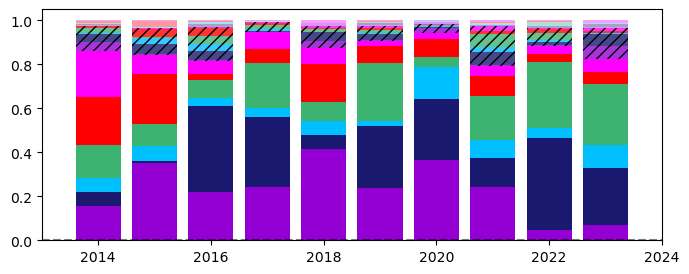

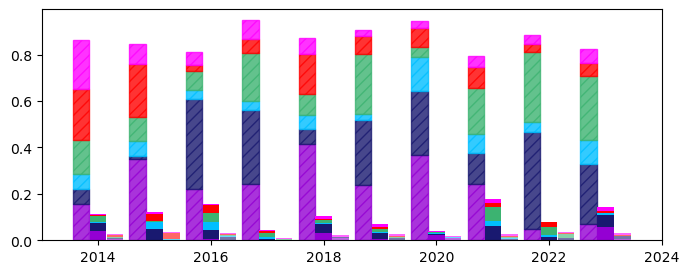

In [12]:
df = pd.concat([math_up14[['year','section','tempP','tempQ','tempX']][:-1],math_up15[['year','section','tempP','tempQ','tempX']][:-1],
    math_up16[['year','section','tempP','tempQ','tempX']][:-1],math_up17[['year','section','tempP','tempQ','tempX']][:-1],
    math_up18[['year','section','tempP','tempQ','tempX']][:-1],math_up19[['year','section','tempP','tempQ','tempX']][:-1],
    math_up20[['year','section','tempP','tempQ','tempX']][:-1],math_up21[['year','section','tempP','tempQ','tempX']][:-1],
    math_up22[['year','section','tempP','tempQ','tempX']][:-1],math_up23[['year','section','tempP','tempQ','tempX']][:-1]])

# Calculate absolute values
df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()

# Normalize the data within each year
df['total_abs'] = df.groupby('year')[['absP', 'absQ', 'absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

# Aggregate normalized values by year and section
agg_df = df.groupby(['year', 'section'])[['normP', 'normQ','normX']].sum().reset_index()

# Pivot the DataFrame for plotting
pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)
pivotX = agg_df.pivot(index='year', columns='section', values='normX').fillna(0)

fig, ax = plt.subplots(1,1,figsize=[8,3])
# Plot normalized Q values
cum_values = np.zeros(len(pivotP))

ax.plot([2013,2024],[0,0],'k--',alpha=0.5)
ax.set_xlim([2013,2024])

colors = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
sections = ['cuc','off_d','off_s','north','south','fresh']
# for i, section in enumerate(pivotP.columns):
for i, section in enumerate(sections):
        ax.bar(pivotQ.index, pivotQ[section], bottom=cum_values, color=colors[i % len(colors)], label=section)
        cum_values += pivotQ[section]

for i, section in enumerate(sections):
        ax.bar(pivotP.index, pivotP[section], bottom=cum_values, color=colors[i % len(colors)], alpha=0.8, hatch='///', label=section)
        cum_values += pivotP[section]

for i, section in enumerate(sections):
        ax.bar(pivotX.index, pivotX[section], bottom=cum_values, color=colors[i % len(colors)], alpha=0.4, label=section)
        cum_values += pivotX[section]


fig, ax = plt.subplots(1,1,figsize=[8,3])
# Plot normalized Q values
cum_values = np.zeros(len(pivotP))
ax.set_xlim([2013,2024])

colors = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
sections = ['cuc','off_d','off_s','north','south','fresh']
# for i, section in enumerate(pivotP.columns):
cum_values = np.zeros(len(pivotP))
for i, section in enumerate(sections):
        ax.bar(pivotQ.index-0.3, pivotQ[section], bottom=cum_values, color=colors[i % len(colors)], edgecolor=colors[i % len(colors)], hatch='///', alpha=0.8, width=0.29, label=section)
        cum_values += pivotQ[section]

cum_values = np.zeros(len(pivotP))
for i, section in enumerate(sections):
        ax.bar(pivotP.index, pivotP[section], bottom=cum_values, color=colors[i % len(colors)], width=0.29, label=section)
        cum_values += pivotP[section]

cum_values = np.zeros(len(pivotP))
for i, section in enumerate(sections):
        ax.bar(pivotX.index+0.3, pivotX[section], bottom=cum_values, color=colors[i % len(colors)], alpha=0.6, width=0.29, label=section)
        cum_values += pivotX[section]


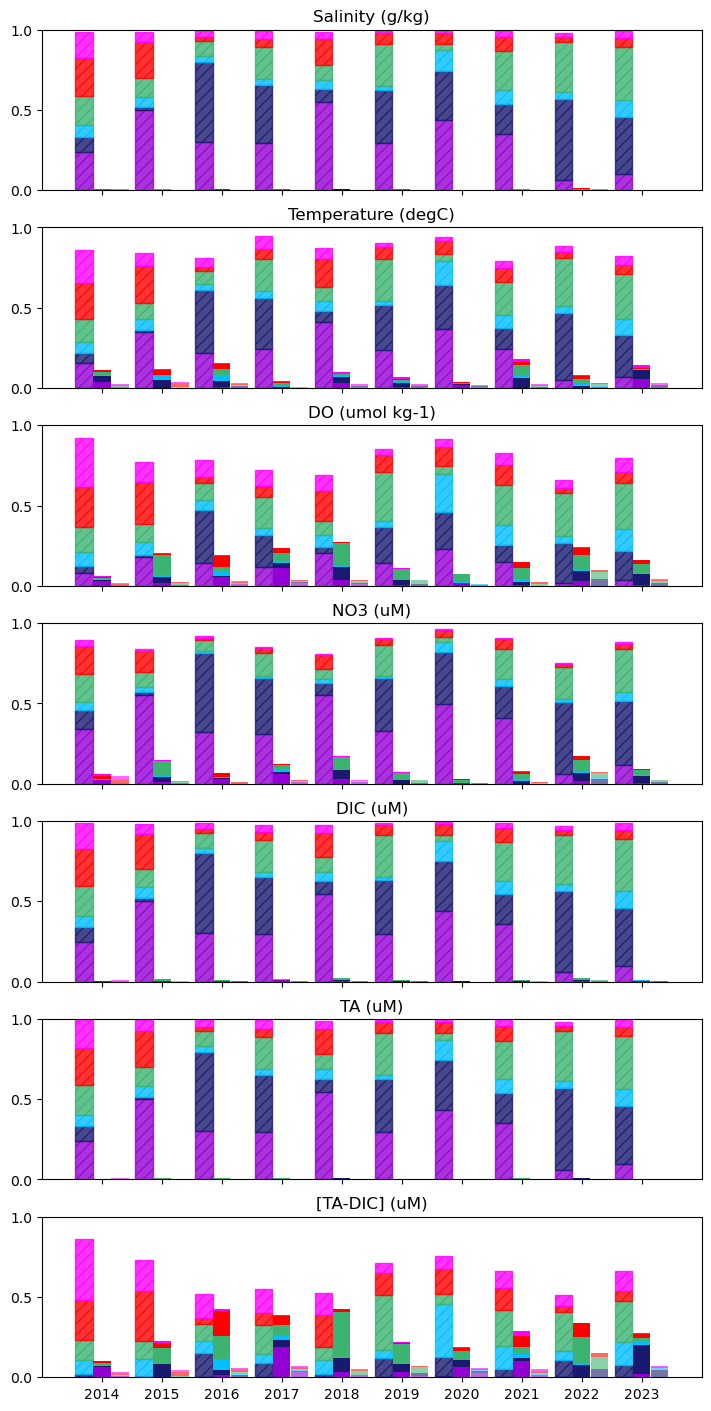

In [13]:
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[7,2*7])
gs = GridSpec(7, 1, figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])
ax7 = fig.add_subplot(gs[6])

# SALINITY
df = pd.concat([math_up14[['year','section','saltP','saltQ','saltX']][:-1],math_up15[['year','section','saltP','saltQ','saltX']][:-1],
    math_up16[['year','section','saltP','saltQ','saltX']][:-1],math_up17[['year','section','saltP','saltQ','saltX']][:-1],
    math_up18[['year','section','saltP','saltQ','saltX']][:-1],math_up19[['year','section','saltP','saltQ','saltX']][:-1],
    math_up20[['year','section','saltP','saltQ','saltX']][:-1],math_up21[['year','section','saltP','saltQ','saltX']][:-1],
    math_up22[['year','section','saltP','saltQ','saltX']][:-1],math_up23[['year','section','saltP','saltQ','saltX']][:-1]])
three_bar(df,'Salinity (g/kg)',ax1)

# TEMPERATURE
df = pd.concat([math_up14[['year','section','tempP','tempQ','tempX']][:-1],math_up15[['year','section','tempP','tempQ','tempX']][:-1],
    math_up16[['year','section','tempP','tempQ','tempX']][:-1],math_up17[['year','section','tempP','tempQ','tempX']][:-1],
    math_up18[['year','section','tempP','tempQ','tempX']][:-1],math_up19[['year','section','tempP','tempQ','tempX']][:-1],
    math_up20[['year','section','tempP','tempQ','tempX']][:-1],math_up21[['year','section','tempP','tempQ','tempX']][:-1],
    math_up22[['year','section','tempP','tempQ','tempX']][:-1],math_up23[['year','section','tempP','tempQ','tempX']][:-1]])
three_bar(df,'Temperature (degC)',ax2)

# DO
df = pd.concat([math_up14[['year','section','DOP','DOQ','DOX']][:-1],math_up15[['year','section','DOP','DOQ','DOX']][:-1],
    math_up16[['year','section','DOP','DOQ','DOX']][:-1],math_up17[['year','section','DOP','DOQ','DOX']][:-1],
    math_up18[['year','section','DOP','DOQ','DOX']][:-1],math_up19[['year','section','DOP','DOQ','DOX']][:-1],
    math_up20[['year','section','DOP','DOQ','DOX']][:-1],math_up21[['year','section','DOP','DOQ','DOX']][:-1],
    math_up22[['year','section','DOP','DOQ','DOX']][:-1],math_up23[['year','section','DOP','DOQ','DOX']][:-1]])
three_bar(df,'DO (umol kg-1)',ax3)

# NO3
df = pd.concat([math_up14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_up15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_up16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_up17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_up18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_up19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_up20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_up21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_up22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_up23[['year','section','NO3P','NO3Q','NO3X']][:-1],])
three_bar(df,'NO3 (uM)',ax4)

# DIC
df = pd.concat([math_up14[['year','section','DICP','DICQ','DICX']][:-1],math_up15[['year','section','DICP','DICQ','DICX']][:-1],
    math_up16[['year','section','DICP','DICQ','DICX']][:-1],math_up17[['year','section','DICP','DICQ','DICX']][:-1],
    math_up18[['year','section','DICP','DICQ','DICX']][:-1],math_up19[['year','section','DICP','DICQ','DICX']][:-1],
    math_up20[['year','section','DICP','DICQ','DICX']][:-1],math_up21[['year','section','DICP','DICQ','DICX']][:-1],
    math_up22[['year','section','DICP','DICQ','DICX']][:-1],math_up23[['year','section','DICP','DICQ','DICX']][:-1],])
three_bar(df,'DIC (uM)',ax5)

# TA
df = pd.concat([math_up14[['year','section','TAP','TAQ','TAX']][:-1],math_up15[['year','section','TAP','TAQ','TAX']][:-1],
    math_up16[['year','section','TAP','TAQ','TAX']][:-1],math_up17[['year','section','TAP','TAQ','TAX']][:-1],
    math_up18[['year','section','TAP','TAQ','TAX']][:-1],math_up19[['year','section','TAP','TAQ','TAX']][:-1],
    math_up20[['year','section','TAP','TAQ','TAX']][:-1],math_up21[['year','section','TAP','TAQ','TAX']][:-1],
    math_up22[['year','section','TAP','TAQ','TAX']][:-1],math_up23[['year','section','TAP','TAQ','TAX']][:-1]])
three_bar(df,'TA (uM)',ax6)

# TA-DIC
df = pd.concat([math_up14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_up15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_up16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_up17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_up18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_up19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_up20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_up21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_up22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_up23[['year','section','TADICP','TADICQ','TADICX']][:-1]])
three_bar(df,'[TA-DIC] (uM)',ax7)

ax7.set_xticklabels(np.arange(2014,2024,1));


# # # build legend handles    
# legend_handles = []
# regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
# colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
# for i in range(len(regions)):
#     legend_handles.append(mlines.Line2D([], [], 
#                           marker='s', linestyle='None',markersize=7,
#                           markeredgecolor=colours[i], markerfacecolor=colours[i],
#                           label=regions[i]))
# # Add a figure-wide legend below the subplots
# ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

## Downwelling

In [14]:
dw13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2014.csv')
dw14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2015.csv')
dw15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2016.csv')
dw16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2017.csv')
dw17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2018.csv')
dw18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2019.csv')
dw19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2020.csv')
dw20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2021.csv')
dw21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2022.csv')
dw22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2023.csv')

In [15]:
# add [TA-DIC] column
files = [dw13,dw14,dw15,dw16,dw17,dw18,dw19,dw20,dw21,dw22]

for file in files:
    file['TA-DIC'] = file.TA - file.DIC

In [16]:
ldw = [113, 143, 149, 198, 91, 163, 53, 82, 105,176] 
# number of days in each downwelling period

In [17]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([dw13.transport*ldw[0],dw14.transport*ldw[1],dw15.transport*ldw[2],dw16.transport*ldw[3],dw17.transport*ldw[4],dw18.transport*ldw[5],
                          dw19.transport*ldw[-4],dw20.transport*ldw[-3],dw21.transport*ldw[-2],dw22.transport*ldw[-1]],axis=0),
     'salt':np.mean([dw13.salt,dw14.salt,dw15.salt,dw16.salt,dw17.salt,dw18.salt,dw19.salt,dw20.salt,dw21.salt,dw22.salt],axis=0),
     'temp':np.mean([dw13.temp,dw14.temp,dw15.temp,dw16.temp,dw17.temp,dw18.temp,dw19.temp,dw20.temp,dw21.temp,dw22.temp],axis=0),
     'DO':np.mean([dw13.DO,dw14.DO,dw15.DO,dw16.DO,dw17.DO,dw18.DO,dw19.DO,dw20.DO,dw21.DO,dw22.DO],axis=0),
     'NO3':np.mean([dw13.NO3,dw14.NO3,dw15.NO3,dw16.NO3,dw17.NO3,dw18.NO3,dw19.NO3,dw20.NO3,dw21.NO3,dw22.NO3],axis=0),
     'TA':np.mean([dw13.TA,dw14.TA,dw15.TA,dw16.TA,dw17.TA,dw18.TA,dw19.TA,dw20.TA,dw21.TA,dw22.TA],axis=0),
     'DIC':np.mean([dw13.DIC,dw14.DIC,dw15.DIC,dw16.DIC,dw17.DIC,dw18.DIC,dw19.DIC,dw20.DIC,dw21.DIC,dw22.DIC],axis=0),
     'TA-DIC':np.mean([dw13['TA-DIC'],dw14['TA-DIC'],dw15['TA-DIC'],dw16['TA-DIC'],dw17['TA-DIC'],dw18['TA-DIC'],dw19['TA-DIC'],dw20['TA-DIC'],dw21['TA-DIC'],dw22['TA-DIC']],axis=0)}
dw_b = pd.DataFrame(d)

dw_b

,section,transport,salt,temp,DO,NO3,TA,DIC,TA-DIC
0,salish,1.908892e+07,32.237827,8.508770,178.519055,23.391358,2241.323549,2176.162661,65.160888
1,cuc,2.671836e+06,33.742330,6.963555,74.114319,35.175855,2310.865668,2312.122887,-1.257219
2,off_d,6.227095e+05,33.621582,6.993844,97.836059,32.141572,2304.149806,2285.640629,18.509177
3,off_s,5.711955e+05,32.724662,9.660364,217.290233,13.468248,2261.764225,2136.413558,125.350666
4,north,1.979996e+05,32.771191,9.212934,193.807149,17.139795,2262.985714,2164.807642,98.178072
5,south,4.797785e+06,32.826371,9.545874,196.776244,17.670007,2268.599650,2171.254125,97.345526
6,fresh,2.985310e+06,30.240506,10.016067,289.855536,7.857657,2168.468826,1998.813766,169.655059
7,loop,7.242081e+06,31.884531,8.321166,187.129456,26.569484,2220.937790,2171.930026,49.007764


In [18]:
dw13.transport = dw13.transport*ldw[0]
dw14.transport = dw14.transport*ldw[1]
dw15.transport = dw15.transport*ldw[2]
dw16.transport = dw16.transport*ldw[3]
dw17.transport = dw17.transport*ldw[4]
dw18.transport = dw18.transport*ldw[5]
dw19.transport = dw19.transport*ldw[6]
dw20.transport = dw20.transport*ldw[7]
dw21.transport = dw21.transport*ldw[8]
dw22.transport = dw22.transport*ldw[9]


In [19]:
# math! 
math_dw13 = decomp(dw13,dw_b)[1:]
math_dw15 = decomp(dw15,dw_b)[1:]
math_dw14 = decomp(dw14,dw_b)[1:]
math_dw16 = decomp(dw16,dw_b)[1:]
math_dw17 = decomp(dw17,dw_b)[1:]
math_dw18 = decomp(dw18,dw_b)[1:]
math_dw19 = decomp(dw19,dw_b)[1:]
math_dw20 = decomp(dw20,dw_b)[1:]
math_dw21 = decomp(dw21,dw_b)[1:]
math_dw22 = decomp(dw22,dw_b)[1:]

# add year 
math_dw13['year'] = 2013
math_dw14['year'] = 2014
math_dw15['year'] = 2015
math_dw16['year'] = 2016
math_dw17['year'] = 2017
math_dw18['year'] = 2018
math_dw19['year'] = 2019
math_dw20['year'] = 2020
math_dw21['year'] = 2021
math_dw22['year'] = 2022

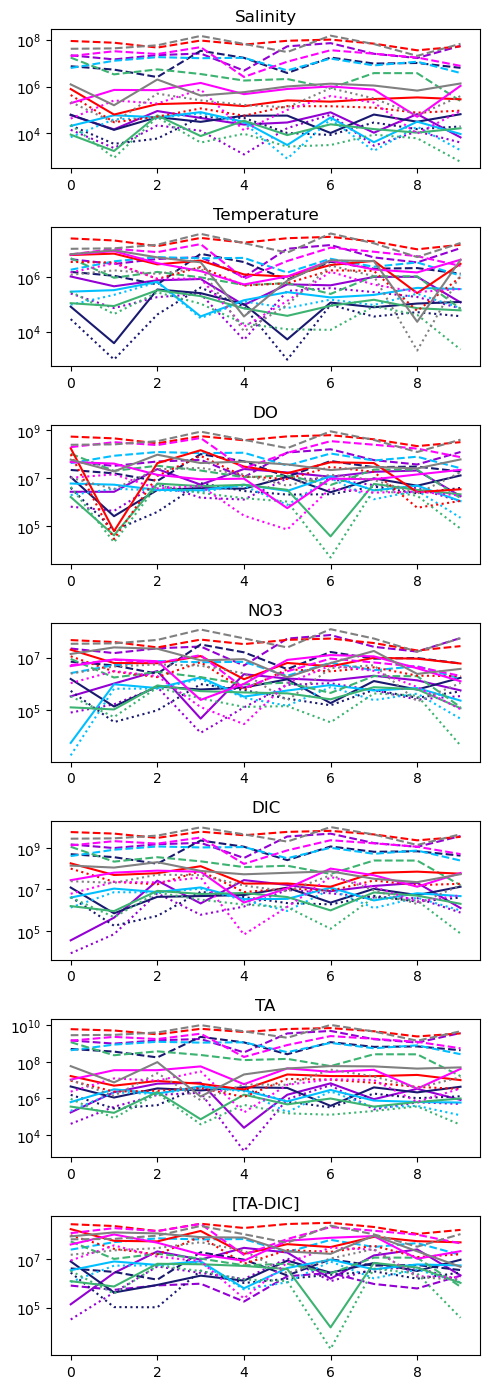

In [20]:
# plot of the magnitude of the terms over time in each water mass and tracer
maths = [math_dw13, math_dw14, math_dw15, math_dw16, math_dw17, math_dw18, math_dw19, math_dw20, math_dw21, math_dw22]
regions = ['cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta','grey']

fig, ax = plt.subplots(7,1,figsize=(5,14))

for i in range(len(math_dw13.section)):
    P = np.abs([math.saltP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.saltQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.saltX[math.section==regions[i]].values for math in maths])
    ax[0].plot(P,color=colours[i])
    ax[0].plot(Q,color=colours[i],ls='dashed')
    ax[0].plot(X,color=colours[i],ls='dotted')
    ax[0].set_yscale('log')
    ax[0].set_title('Salinity')


    P = np.abs([math.tempP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.tempQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.tempX[math.section==regions[i]].values for math in maths])
    ax[1].plot(P,color=colours[i])
    ax[1].plot(Q,color=colours[i],ls='dashed')
    ax[1].plot(X,color=colours[i],ls='dotted')
    ax[1].set_yscale('log')
    ax[1].set_title('Temperature')


    P = np.abs([math.DOP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.DOQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.DOX[math.section==regions[i]].values for math in maths])
    ax[2].plot(P,color=colours[i])
    ax[2].plot(Q,color=colours[i],ls='dashed')
    ax[2].plot(X,color=colours[i],ls='dotted')
    ax[2].set_yscale('log')
    ax[2].set_title('DO')


    P = np.abs([math.NO3P[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.NO3Q[math.section==regions[i]].values for math in maths])
    X = np.abs([math.NO3X[math.section==regions[i]].values for math in maths])
    ax[3].plot(P,color=colours[i])
    ax[3].plot(Q,color=colours[i],ls='dashed')
    ax[3].plot(X,color=colours[i],ls='dotted')
    ax[3].set_yscale('log')
    ax[3].set_title('NO3')


    P = np.abs([math.DICP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.DICQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.DICX[math.section==regions[i]].values for math in maths])
    ax[4].plot(P,color=colours[i])
    ax[4].plot(Q,color=colours[i],ls='dashed')
    ax[4].plot(X,color=colours[i],ls='dotted')
    ax[4].set_yscale('log')
    ax[4].set_title('DIC')


    P = np.abs([math.TAP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.TAQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.TAX[math.section==regions[i]].values for math in maths])
    ax[5].plot(P,color=colours[i])
    ax[5].plot(Q,color=colours[i],ls='dashed')
    ax[5].plot(X,color=colours[i],ls='dotted')
    ax[5].set_yscale('log')
    ax[5].set_title('TA')


    P = np.abs([math.TADICP[math.section==regions[i]].values for math in maths])
    Q = np.abs([math.TADICQ[math.section==regions[i]].values for math in maths])
    X = np.abs([math.TADICX[math.section==regions[i]].values for math in maths])
    ax[6].plot(P,color=colours[i])
    ax[6].plot(Q,color=colours[i],ls='dashed')
    ax[6].plot(X,color=colours[i],ls='dotted')
    ax[6].set_yscale('log')
    ax[6].set_title('[TA-DIC]')

plt.tight_layout()

/tmp/ipykernel_197590/819159033.py:161: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


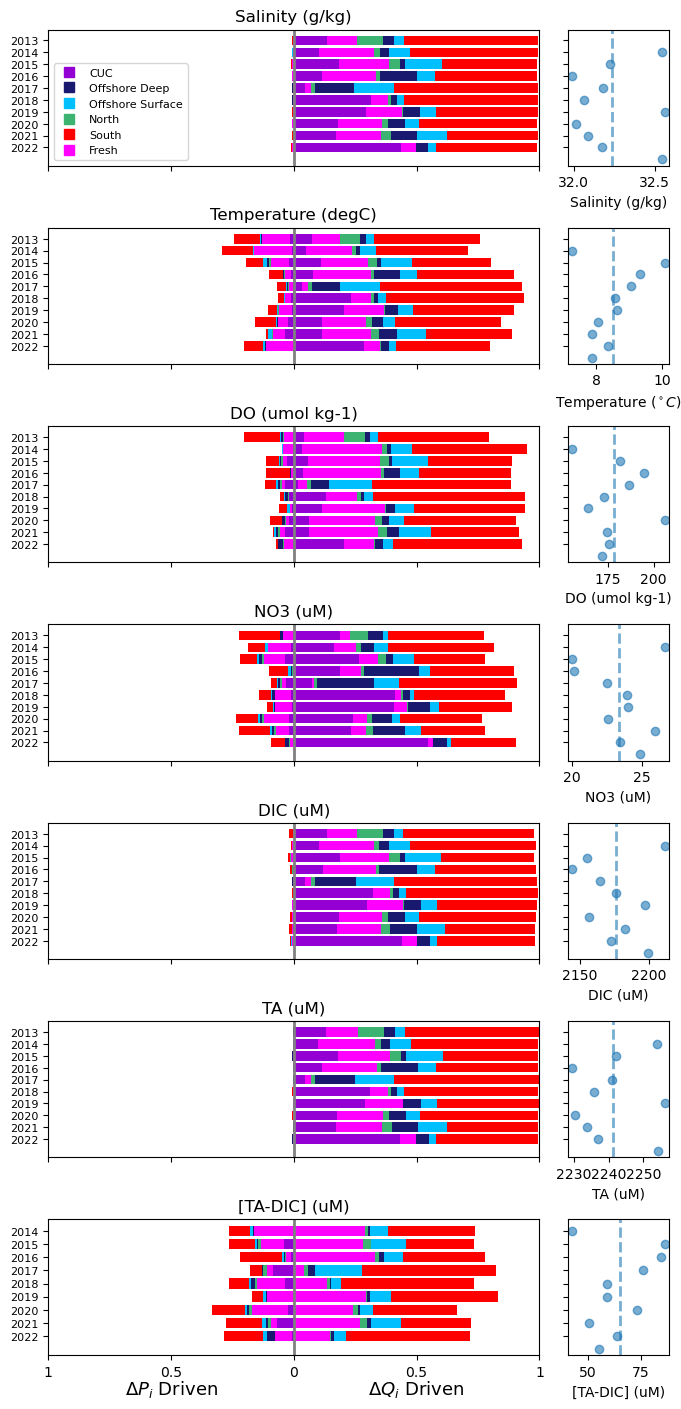

In [21]:
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[7,2*7])
gs = GridSpec(7, 5, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])
ax3 = fig.add_subplot(gs[1, :4])
ax4 = fig.add_subplot(gs[1, 4])
ax5 = fig.add_subplot(gs[2, :4])
ax6 = fig.add_subplot(gs[2, 4])
ax7 = fig.add_subplot(gs[3, :4])
ax8 = fig.add_subplot(gs[3, 4])
ax9 = fig.add_subplot(gs[4, :4])
ax10 = fig.add_subplot(gs[4, 4])
ax11 = fig.add_subplot(gs[5, :4])
ax12 = fig.add_subplot(gs[5, 4])
ax13 = fig.add_subplot(gs[6, :4])
ax14 = fig.add_subplot(gs[6, 4])

# SALINITY
df = pd.concat([math_dw13[['year','section','saltP','saltQ']][:-1],math_dw14[['year','section','saltP','saltQ']][:-1],
    math_dw15[['year','section','saltP','saltQ']][:-1],math_dw16[['year','section','saltP','saltQ']][:-1],
    math_dw17[['year','section','saltP','saltQ']][:-1],math_dw18[['year','section','saltP','saltQ']][:-1],
    math_dw19[['year','section','saltP','saltQ']][:-1],math_dw20[['year','section','saltP','saltQ']][:-1],
    math_dw21[['year','section','saltP','saltQ']][:-1],math_dw22[['year','section','saltP','saltQ']][:-1]])
combined_stacked_bar(df,'Salinity (g/kg)',ax1,ax2)

# mean property inflow to JdF
ax2.scatter([dw13.salt[0],dw14.salt[0],dw15.salt[0],dw16.salt[0],dw17.salt[0],dw18.salt[0],dw19.salt[0],dw20.salt[0],dw21.salt[0],dw22.salt[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:blue')
ax2.axvline(dw_b.salt[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax2.set_xlabel('Salinity (g/kg)',fontsize=10)

# TEMPERATURE
df = pd.concat([math_dw13[['year','section','tempP','tempQ']][:-1],math_dw14[['year','section','tempP','tempQ']][:-1],
    math_dw15[['year','section','tempP','tempQ']][:-1],math_dw16[['year','section','tempP','tempQ']][:-1],
    math_dw17[['year','section','tempP','tempQ']][:-1],math_dw18[['year','section','tempP','tempQ']][:-1],
    math_dw19[['year','section','tempP','tempQ']][:-1],math_dw20[['year','section','tempP','tempQ']][:-1],
    math_dw21[['year','section','tempP','tempQ']][:-1],math_dw22[['year','section','tempP','tempQ']][:-1]])
combined_stacked_bar(df,'Temperature (degC)',ax3,ax4)

# mean property inflow to JdF
ax4.scatter([dw13.temp[0],dw14.temp[0],dw15.temp[0],dw16.temp[0],dw17.temp[0],dw18.temp[0],dw19.temp[0],dw20.temp[0],dw21.temp[0],dw22.temp[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:blue')
ax4.axvline(dw_b.temp[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax4.set_xlabel('Temperature ($^\circ C$)',fontsize=10)

# DO
df = pd.concat([math_dw13[['year','section','DOP','DOQ']][:-1],math_dw14[['year','section','DOP','DOQ']][:-1],
    math_dw15[['year','section','DOP','DOQ']][:-1],math_dw16[['year','section','DOP','DOQ']][:-1],
    math_dw17[['year','section','DOP','DOQ']][:-1],math_dw18[['year','section','DOP','DOQ']][:-1],
    math_dw19[['year','section','DOP','DOQ']][:-1],math_dw20[['year','section','DOP','DOQ']][:-1],
    math_dw21[['year','section','DOP','DOQ']][:-1],math_dw22[['year','section','DOP','DOQ']][:-1]])
combined_stacked_bar(df,'DO (umol kg-1)',ax5,ax6)

# mean property inflow to JdF
ax6.scatter([dw13.DO[0],dw14.DO[0],dw15.DO[0],dw16.DO[0],dw17.DO[0],dw18.DO[0],dw19.DO[0],dw20.DO[0],dw21.DO[0],dw22.DO[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:blue')
ax6.axvline(dw_b.DO[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax6.set_xlabel('DO (umol kg-1)',fontsize=10)

# NO3
df = pd.concat([math_dw13[['year','section','NO3P','NO3Q']][:-1],math_dw14[['year','section','NO3P','NO3Q']][:-1],
    math_dw15[['year','section','NO3P','NO3Q']][:-1],math_dw16[['year','section','NO3P','NO3Q']][:-1],
    math_dw17[['year','section','NO3P','NO3Q']][:-1],math_dw18[['year','section','NO3P','NO3Q']][:-1],
    math_dw19[['year','section','NO3P','NO3Q']][:-1],math_dw20[['year','section','NO3P','NO3Q']][:-1],
    math_dw21[['year','section','NO3P','NO3Q']][:-1],math_dw22[['year','section','NO3P','NO3Q']][:-1],])
combined_stacked_bar(df,'NO3 (uM)',ax7,ax8)

# mean property inflow to JdF
ax8.scatter([dw13.NO3[0],dw14.NO3[0],dw15.NO3[0],dw16.NO3[0],dw17.NO3[0],dw18.NO3[0],dw19.NO3[0],dw20.NO3[0],dw21.NO3[0],dw22.NO3[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:blue')
ax8.axvline(dw_b.NO3[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax8.set_xlabel('NO3 (uM)',fontsize=10)

# DIC
df = pd.concat([math_dw13[['year','section','DICP','DICQ']][:-1],math_dw14[['year','section','DICP','DICQ']][:-1],
    math_dw15[['year','section','DICP','DICQ']][:-1],math_dw16[['year','section','DICP','DICQ']][:-1],
    math_dw17[['year','section','DICP','DICQ']][:-1],math_dw18[['year','section','DICP','DICQ']][:-1],
    math_dw19[['year','section','DICP','DICQ']][:-1],math_dw20[['year','section','DICP','DICQ']][:-1],
    math_dw21[['year','section','DICP','DICQ']][:-1],math_dw22[['year','section','DICP','DICQ']][:-1],])
combined_stacked_bar(df,'DIC (uM)',ax9,ax10)

# mean property inflow to JdF
ax10.scatter([dw13.DIC[0],dw14.DIC[0],dw15.DIC[0],dw16.DIC[0],dw17.DIC[0],dw18.DIC[0],dw19.DIC[0],dw20.DIC[0],dw21.DIC[0],dw22.DIC[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:blue')
ax10.axvline(dw_b.DIC[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax10.set_xlabel('DIC (uM)',fontsize=10)

# TA
df = pd.concat([math_dw13[['year','section','TAP','TAQ']][:-1],math_dw14[['year','section','TAP','TAQ']][:-1],
    math_dw15[['year','section','TAP','TAQ']][:-1],math_dw16[['year','section','TAP','TAQ']][:-1],
    math_dw17[['year','section','TAP','TAQ']][:-1],math_dw18[['year','section','TAP','TAQ']][:-1],
    math_dw19[['year','section','TAP','TAQ']][:-1],math_dw20[['year','section','TAP','TAQ']][:-1],
    math_dw21[['year','section','TAP','TAQ']][:-1],math_dw22[['year','section','TAP','TAQ']][:-1]])
combined_stacked_bar(df,'TA (uM)',ax11,ax12)

# mean property inflow to JdF
ax12.scatter([dw13.TA[0],dw14.TA[0],dw15.TA[0],dw16.TA[0],dw17.TA[0],dw18.TA[0],dw19.TA[0],dw20.TA[0],dw21.TA[0],dw22.TA[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:blue')
ax12.axvline(dw_b.TA[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax12.set_xlabel('TA (uM)',fontsize=10)

# TA-DIC
df = pd.concat([math_dw14[['year','section','TADICP','TADICQ']][:-1],math_dw15[['year','section','TADICP','TADICQ']][:-1],
    math_dw16[['year','section','TADICP','TADICQ']][:-1],math_dw17[['year','section','TADICP','TADICQ']][:-1],
    math_dw18[['year','section','TADICP','TADICQ']][:-1],math_dw19[['year','section','TADICP','TADICQ']][:-1],
    math_dw20[['year','section','TADICP','TADICQ']][:-1],math_dw21[['year','section','TADICP','TADICQ']][:-1],
    math_dw22[['year','section','TADICP','TADICQ']][:-1]])
combined_stacked_bar(df,'[TA-DIC] (uM)',ax13,ax14)

# mean property inflow to JdF
ax14.scatter([dw13['TA-DIC'][0],dw14['TA-DIC'][0],dw15['TA-DIC'][0],dw16['TA-DIC'][0],dw17['TA-DIC'][0],dw18['TA-DIC'][0],dw19['TA-DIC'][0],dw20['TA-DIC'][0],dw21['TA-DIC'][0],dw22['TA-DIC'][0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:blue')
ax14.axvline(dw_b['TA-DIC'][0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax14.set_xlabel('[TA-DIC] (uM)',fontsize=10)

ax13.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax13.text(.25, -0.32, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax13.transAxes, fontsize=13)
ax13.text(.75, -0.32, r'$\Delta Q_i$ Driven', ha='center', va='bottom', transform=ax13.transAxes, fontsize=13)

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

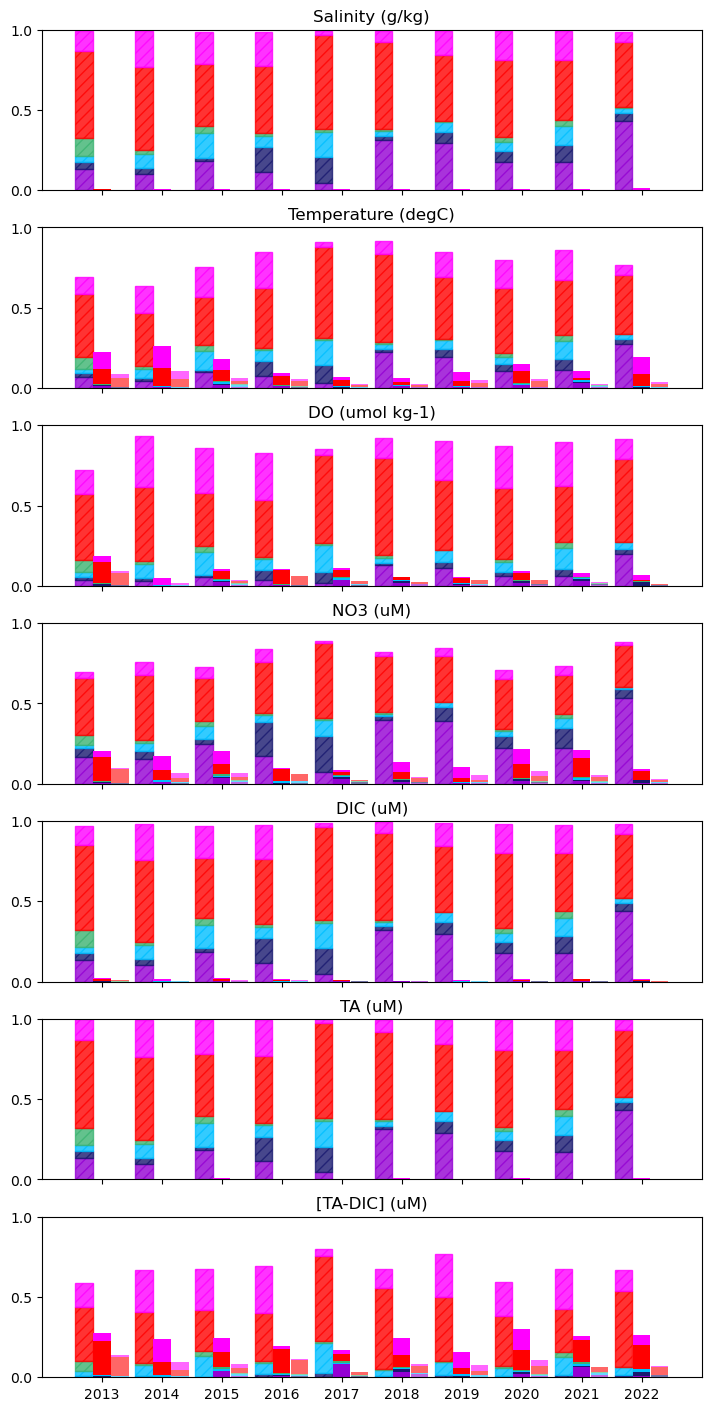

In [22]:
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[7,2*7])
gs = GridSpec(7, 1, figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])
ax7 = fig.add_subplot(gs[6])

# SALINITY
df = pd.concat([math_dw13[['year','section','saltP','saltQ','saltX']][:-1],math_dw14[['year','section','saltP','saltQ','saltX']][:-1],math_dw15[['year','section','saltP','saltQ','saltX']][:-1],
    math_dw16[['year','section','saltP','saltQ','saltX']][:-1],math_dw17[['year','section','saltP','saltQ','saltX']][:-1],
    math_dw18[['year','section','saltP','saltQ','saltX']][:-1],math_dw19[['year','section','saltP','saltQ','saltX']][:-1],
    math_dw20[['year','section','saltP','saltQ','saltX']][:-1],math_dw21[['year','section','saltP','saltQ','saltX']][:-1],
    math_dw22[['year','section','saltP','saltQ','saltX']][:-1]])
three_bar(df,'Salinity (g/kg)',ax1)

# TEMPERATURE
df = pd.concat([math_dw13[['year','section','tempP','tempQ','tempX']][:-1],math_dw14[['year','section','tempP','tempQ','tempX']][:-1],math_dw15[['year','section','tempP','tempQ','tempX']][:-1],
    math_dw16[['year','section','tempP','tempQ','tempX']][:-1],math_dw17[['year','section','tempP','tempQ','tempX']][:-1],
    math_dw18[['year','section','tempP','tempQ','tempX']][:-1],math_dw19[['year','section','tempP','tempQ','tempX']][:-1],
    math_dw20[['year','section','tempP','tempQ','tempX']][:-1],math_dw21[['year','section','tempP','tempQ','tempX']][:-1],
    math_dw22[['year','section','tempP','tempQ','tempX']][:-1]])
three_bar(df,'Temperature (degC)',ax2)

# DO
df = pd.concat([math_dw13[['year','section','DOP','DOQ','DOX']][:-1],math_dw14[['year','section','DOP','DOQ','DOX']][:-1],math_dw15[['year','section','DOP','DOQ','DOX']][:-1],
    math_dw16[['year','section','DOP','DOQ','DOX']][:-1],math_dw17[['year','section','DOP','DOQ','DOX']][:-1],
    math_dw18[['year','section','DOP','DOQ','DOX']][:-1],math_dw19[['year','section','DOP','DOQ','DOX']][:-1],
    math_dw20[['year','section','DOP','DOQ','DOX']][:-1],math_dw21[['year','section','DOP','DOQ','DOX']][:-1],
    math_dw22[['year','section','DOP','DOQ','DOX']][:-1]])
three_bar(df,'DO (umol kg-1)',ax3)

# NO3
df = pd.concat([math_dw13[['year','section','NO3P','NO3Q','NO3X']][:-1],math_dw14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_dw15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_dw16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_dw17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_dw18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_dw19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_dw20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_dw21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_dw22[['year','section','NO3P','NO3Q','NO3X']][:-1],])
three_bar(df,'NO3 (uM)',ax4)

# DIC
df = pd.concat([math_dw13[['year','section','DICP','DICQ','DICX']][:-1],math_dw14[['year','section','DICP','DICQ','DICX']][:-1],math_dw15[['year','section','DICP','DICQ','DICX']][:-1],
    math_dw16[['year','section','DICP','DICQ','DICX']][:-1],math_dw17[['year','section','DICP','DICQ','DICX']][:-1],
    math_dw18[['year','section','DICP','DICQ','DICX']][:-1],math_dw19[['year','section','DICP','DICQ','DICX']][:-1],
    math_dw20[['year','section','DICP','DICQ','DICX']][:-1],math_dw21[['year','section','DICP','DICQ','DICX']][:-1],
    math_dw22[['year','section','DICP','DICQ','DICX']][:-1],])
three_bar(df,'DIC (uM)',ax5)

# TA
df = pd.concat([math_dw13[['year','section','TAP','TAQ','TAX']][:-1],math_dw14[['year','section','TAP','TAQ','TAX']][:-1],math_dw15[['year','section','TAP','TAQ','TAX']][:-1],
    math_dw16[['year','section','TAP','TAQ','TAX']][:-1],math_dw17[['year','section','TAP','TAQ','TAX']][:-1],
    math_dw18[['year','section','TAP','TAQ','TAX']][:-1],math_dw19[['year','section','TAP','TAQ','TAX']][:-1],
    math_dw20[['year','section','TAP','TAQ','TAX']][:-1],math_dw21[['year','section','TAP','TAQ','TAX']][:-1],
    math_dw22[['year','section','TAP','TAQ','TAX']][:-1],])
three_bar(df,'TA (uM)',ax6)

# TA-DIC
df = pd.concat([math_dw13[['year','section','TADICP','TADICQ','TADICX']][:-1],math_dw14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_dw15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_dw16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_dw17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_dw18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_dw19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_dw20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_dw21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_dw22[['year','section','TADICP','TADICQ','TADICX']][:-1],])
three_bar(df,'[TA-DIC] (uM)',ax7)

ax7.set_xticklabels(np.sort(list(set(df.year))));


# # # build legend handles    
# legend_handles = []
# regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
# colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
# for i in range(len(regions)):
#     legend_handles.append(mlines.Line2D([], [], 
#                           marker='s', linestyle='None',markersize=7,
#                           markeredgecolor=colours[i], markerfacecolor=colours[i],
#                           label=regions[i]))
# # Add a figure-wide legend below the subplots
# ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

## All together now

In [23]:
d = {'2013':up13.transport[1:],'2014':up14.transport[1:],'2015':up15.transport[1:],
     '2016':up16.transport[1:],'2017':up17.transport[1:],'2018':up18.transport[1:],
     '2019':up19.transport[1:],'2020':up20.transport[1:],'2021':up21.transport[1:],
     '2022':up22.transport[1:],'2023':up23.transport[1:]}
up = pd.DataFrame(d)

d = {'2014':dw13.transport[1:],'2015':dw14.transport[1:],'2016':dw15.transport[1:],
     '2017':dw16.transport[1:],'2018':dw17.transport[1:],'2019':dw18.transport[1:],
     '2020':dw19.transport[1:],'2021':dw20.transport[1:],'2022':dw21.transport[1:],
     '2023':dw22.transport[1:]}
dw = pd.DataFrame(d)

regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh', 'Loop']

In [24]:
# transport weighted means of the inflowing properties
salt = {'2014':np.average([up14.salt[0],dw13.salt[0]],weights=[up14.transport[0],dw13.transport[0]]),'2015':np.average([up15.salt[0],dw14.salt[0]],weights=[up15.transport[0],dw14.transport[0]]),
     '2016':np.average([up16.salt[0],dw15.salt[0]],weights=[up16.transport[0],dw15.transport[0]]),'2017':np.average([up17.salt[0],dw16.salt[0]],weights=[up17.transport[0],dw16.transport[0]]),
     '2018':np.average([up18.salt[0],dw17.salt[0]],weights=[up18.transport[0],dw17.transport[0]]),'2019':np.average([up19.salt[0],dw18.salt[0]],weights=[up19.transport[0],dw18.transport[0]]),
     '2020':np.average([up20.salt[0],dw19.salt[0]],weights=[up20.transport[0],dw20.transport[0]]),'2021':np.average([up21.salt[0],dw20.salt[0]],weights=[up21.transport[0],dw20.transport[0]]),
     '2022':np.average([up22.salt[0],dw21.salt[0]],weights=[up22.transport[0],dw21.transport[0]]),'2023':np.average([up23.salt[0],dw22.salt[0]],weights=[up23.transport[0],dw22.transport[0]])}

temp = {'2014':np.average([up14.temp[0],dw13.temp[0]],weights=[up14.transport[0],dw13.transport[0]]),'2015':np.average([up15.temp[0],dw14.temp[0]],weights=[up15.transport[0],dw14.transport[0]]),
     '2016':np.average([up16.temp[0],dw15.temp[0]],weights=[up16.transport[0],dw15.transport[0]]),'2017':np.average([up17.temp[0],dw16.temp[0]],weights=[up17.transport[0],dw16.transport[0]]),
     '2018':np.average([up18.temp[0],dw17.temp[0]],weights=[up18.transport[0],dw17.transport[0]]),
     '2019':np.average([up19.temp[0],dw18.temp[0]],weights=[up19.transport[0],dw18.transport[0]]),'2020':np.average([up20.temp[0],dw19.temp[0]],weights=[up20.transport[0],dw20.transport[0]]),
     '2021':np.average([up21.temp[0],dw20.temp[0]],weights=[up21.transport[0],dw20.transport[0]]),'2022':np.average([up22.temp[0],dw21.temp[0]],weights=[up22.transport[0],dw21.transport[0]]),
     '2023':np.average([up23.temp[0],dw22.temp[0]],weights=[up23.transport[0],dw22.transport[0]])}

DO = {'2014':np.average([up14.DO[0],dw13.DO[0]],weights=[up14.transport[0],dw13.transport[0]]),'2015':np.average([up15.DO[0],dw14.DO[0]],weights=[up15.transport[0],dw14.transport[0]]),
     '2016':np.average([up16.DO[0],dw15.DO[0]],weights=[up16.transport[0],dw15.transport[0]]),'2017':np.average([up17.DO[0],dw16.DO[0]],weights=[up17.transport[0],dw16.transport[0]]),
     '2018':np.average([up18.DO[0],dw17.DO[0]],weights=[up18.transport[0],dw17.transport[0]]),
     '2019':np.average([up19.DO[0],dw18.DO[0]],weights=[up19.transport[0],dw18.transport[0]]),'2020':np.average([up20.DO[0],dw19.DO[0]],weights=[up20.transport[0],dw20.transport[0]]),
     '2021':np.average([up21.DO[0],dw20.DO[0]],weights=[up21.transport[0],dw20.transport[0]]),'2022':np.average([up22.DO[0],dw21.DO[0]],weights=[up22.transport[0],dw21.transport[0]]),
     '2023':np.average([up23.DO[0],dw22.DO[0]],weights=[up23.transport[0],dw22.transport[0]])}

NO3 = {'2014':np.average([up14.NO3[0],dw13.NO3[0]],weights=[up14.transport[0],dw13.transport[0]]),'2015':np.average([up15.NO3[0],dw14.NO3[0]],weights=[up15.transport[0],dw14.transport[0]]),
     '2016':np.average([up16.NO3[0],dw15.NO3[0]],weights=[up16.transport[0],dw15.transport[0]]),'2017':np.average([up17.NO3[0],dw16.NO3[0]],weights=[up17.transport[0],dw16.transport[0]]),
     '2018':np.average([up18.NO3[0],dw17.NO3[0]],weights=[up18.transport[0],dw17.transport[0]]),
     '2019':np.average([up19.NO3[0],dw18.NO3[0]],weights=[up19.transport[0],dw18.transport[0]]),'2020':np.average([up20.NO3[0],dw19.NO3[0]],weights=[up20.transport[0],dw20.transport[0]]),
     '2021':np.average([up21.NO3[0],dw20.NO3[0]],weights=[up21.transport[0],dw20.transport[0]]),'2022':np.average([up22.NO3[0],dw21.NO3[0]],weights=[up22.transport[0],dw21.transport[0]]),
     '2023':np.average([up23.NO3[0],dw22.NO3[0]],weights=[up23.transport[0],dw22.transport[0]])}

TA = {'2014':np.average([up14.TA[0],dw13.TA[0]],weights=[up14.transport[0],dw13.transport[0]]),'2015':np.average([up15.TA[0],dw14.TA[0]],weights=[up15.transport[0],dw14.transport[0]]),
     '2016':np.average([up16.TA[0],dw15.TA[0]],weights=[up16.transport[0],dw15.transport[0]]),'2017':np.average([up17.TA[0],dw16.TA[0]],weights=[up17.transport[0],dw16.transport[0]]),
     '2018':np.average([up18.TA[0],dw17.TA[0]],weights=[up18.transport[0],dw17.transport[0]]),
     '2019':np.average([up19.TA[0],dw18.TA[0]],weights=[up19.transport[0],dw18.transport[0]]),'2020':np.average([up20.TA[0],dw19.TA[0]],weights=[up20.transport[0],dw20.transport[0]]),
     '2021':np.average([up21.TA[0],dw20.TA[0]],weights=[up21.transport[0],dw20.transport[0]]),'2022':np.average([up22.TA[0],dw21.TA[0]],weights=[up22.transport[0],dw21.transport[0]]),
     '2023':np.average([up23.TA[0],dw22.TA[0]],weights=[up23.transport[0],dw22.transport[0]])}

DIC = {'2014':np.average([up14.DIC[0],dw13.DIC[0]],weights=[up14.transport[0],dw13.transport[0]]),'2015':np.average([up15.DIC[0],dw14.DIC[0]],weights=[up15.transport[0],dw14.transport[0]]),
     '2016':np.average([up16.DIC[0],dw15.DIC[0]],weights=[up16.transport[0],dw15.transport[0]]),'2017':np.average([up17.DIC[0],dw16.DIC[0]],weights=[up17.transport[0],dw16.transport[0]]),
     '2018':np.average([up18.DIC[0],dw17.DIC[0]],weights=[up18.transport[0],dw17.transport[0]]),
     '2019':np.average([up19.DIC[0],dw18.DIC[0]],weights=[up19.transport[0],dw18.transport[0]]),'2020':np.average([up20.DIC[0],dw19.DIC[0]],weights=[up20.transport[0],dw20.transport[0]]),
     '2021':np.average([up21.DIC[0],dw20.DIC[0]],weights=[up21.transport[0],dw20.transport[0]]),'2022':np.average([up22.DIC[0],dw21.DIC[0]],weights=[up22.transport[0],dw21.transport[0]]),
     '2023':np.average([up23.DIC[0],dw22.DIC[0]],weights=[up23.transport[0],dw22.transport[0]])}

TADIC = {'2014':np.average([up14['TA-DIC'][0],dw13['TA-DIC'][0]],weights=[up14.transport[0],dw13.transport[0]]),'2015':np.average([up15['TA-DIC'][0],dw14['TA-DIC'][0]],weights=[up15.transport[0],dw14.transport[0]]),
     '2016':np.average([up16['TA-DIC'][0],dw15['TA-DIC'][0]],weights=[up16.transport[0],dw15.transport[0]]),'2017':np.average([up17['TA-DIC'][0],dw16['TA-DIC'][0]],weights=[up17.transport[0],dw16.transport[0]]),
     '2018':np.average([up18['TA-DIC'][0],dw17['TA-DIC'][0]],weights=[up18.transport[0],dw17.transport[0]]),
     '2019':np.average([up19['TA-DIC'][0],dw18['TA-DIC'][0]],weights=[up19.transport[0],dw18.transport[0]]),'2020':np.average([up20['TA-DIC'][0],dw19['TA-DIC'][0]],weights=[up20.transport[0],dw20.transport[0]]),
     '2021':np.average([up21['TA-DIC'][0],dw20['TA-DIC'][0]],weights=[up21.transport[0],dw20.transport[0]]),'2022':np.average([up22['TA-DIC'][0],dw21['TA-DIC'][0]],weights=[up22.transport[0],dw21.transport[0]]),
     '2023':np.average([up23['TA-DIC'][0],dw22['TA-DIC'][0]],weights=[up23.transport[0],dw22.transport[0]])}

Text(0.01, 0.05, 'g)')

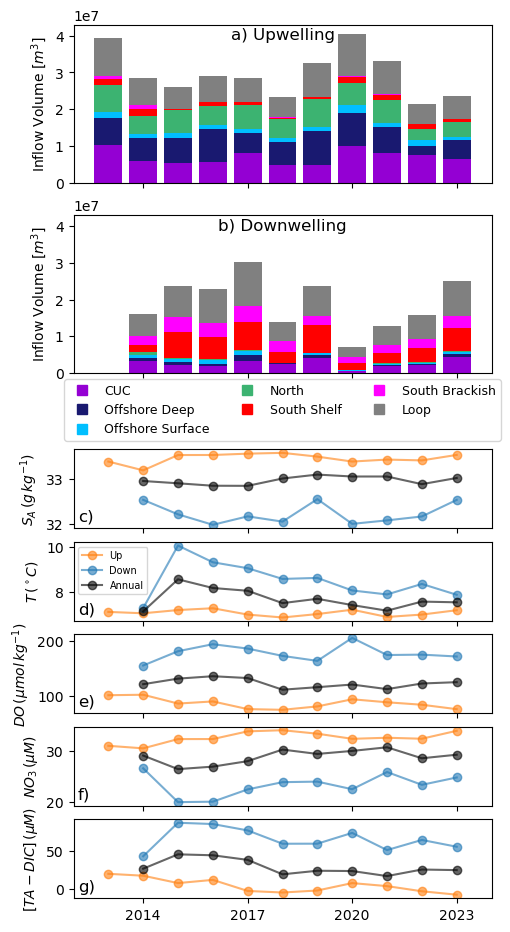

In [25]:
## maybe it makes more sense to plot interannual varriability in watermass inflow with average properties
# Assign colors to each section
colors = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta','grey']

# fig, ax = plt.subplots(8,1,figsize=[5,3*8])
fig = plt.figure(constrained_layout=True, figsize=[5,10])
gs = GridSpec(10, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[2:4,0])
ax3 = fig.add_subplot(gs[4, 0])
ax4 = fig.add_subplot(gs[5,0])
ax5 = fig.add_subplot(gs[6, 0])
ax6 = fig.add_subplot(gs[7,0])
ax7 = fig.add_subplot(gs[8, 0])

#Bars of upwlling and downwelling transport from each water mass
# Plot upwelling
up_cum_values = np.zeros(len(up.columns))
for i in range(len(up)):
    bars = ax1.bar(pd.to_numeric((up.columns)), up.iloc[i,:], bottom=up_cum_values, color=colors[i % len(colors)])
    up_cum_values += up.iloc[i,:]
ax1.text(.5, 0.98, 'a) Upwelling', ha='center', va='top', transform=ax1.transAxes, fontsize=12)

# Plot downwelling
dw_cum_values = np.zeros(len(dw.columns))
for i in range(len(up)):
    bars = ax2.bar(pd.to_numeric((dw.columns)), dw.iloc[i,:], bottom=dw_cum_values, color=colors[i % len(colors)])
    dw_cum_values += dw.iloc[i,:]
ax2.text(.5, 0.98, 'b) Downwelling', ha='center', va='top', transform=ax2.transAxes, fontsize=12)

# Customize plot
for axs in [ax1,ax2]:
    axs.set_ylim(0,43000000)
    # axs.set_yticks([0,50000,150000])
    # axs.set_yticklabels([0,50,150])
    axs.set_ylabel('Inflow Volume [$m^3$]')
for axs in [ax1,ax2,ax3,ax4,ax5,ax6,ax7]:
    axs.set_xlim([2012,2024])
    axs.set_xticks([2014,2017,2020,2023])
for axs in [ax1,ax2,ax3,ax4,ax5,ax6]:
    axs.set_xticklabels([])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South Shelf', 'South Brackish','Loop']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta','grey']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
# ax2.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)
ax2.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

# # season length
# axl.plot([2013,2014,2015,2016,2017,2018,2021,2022],[219, 161, 144, 158, 156,128,189, 117], alpha=0.6,c='tab:orange',marker='o')
# axl.plot([2014,2016,2017,2018,2021,2022],[113, 149, 198, 91, 82, 105] , alpha=0.6,c='tab:blue',marker='o')
# axl.set_ylabel('Length [d]')

# Average inflow salinity
ax3.plot(np.arange(2013,2023+1,1),[up13.salt[0],up14.salt[0],up15.salt[0],up16.salt[0],up17.salt[0],up18.salt[0],up19.salt[0],up20.salt[0],up21.salt[0],up22.salt[0],up23.salt[0]], alpha=0.6,c='tab:orange',marker='o',label='Upwelling')
ax3.plot(np.arange(2014,2023+1,1),[dw13.salt[0],dw14.salt[0],dw15.salt[0],dw16.salt[0],dw17.salt[0],dw18.salt[0],dw19.salt[0],dw20.salt[0],dw21.salt[0],dw22.salt[0]], alpha=0.6,c='tab:blue',marker='o',label='Downwelling')
ax3.plot(np.arange(2014,2023+1,1),[salt['2014'],salt['2015'],salt['2016'],salt['2017'],salt['2018'],salt['2019'],salt['2020'],salt['2021'],salt['2022'],salt['2023']], alpha=0.6,c='k',marker='o',label='Annual')
ax3.set_ylabel('$S_A\, (g\, kg^{-1})$')

# Average inflow temperature
ax4.plot(np.arange(2013,2023+1,1),[up13.temp[0],up14.temp[0],up15.temp[0],up16.temp[0],up17.temp[0],up18.temp[0],up19.temp[0],up20.temp[0],up21.temp[0],up22.temp[0],up23.temp[0]], alpha=0.6,c='tab:orange',marker='o',label='Up')
ax4.plot(np.arange(2014,2023+1,1),[dw13.temp[0],dw14.temp[0],dw15.temp[0],dw16.temp[0],dw17.temp[0],dw18.temp[0],dw19.temp[0],dw20.temp[0],dw21.temp[0],dw22.temp[0]], alpha=0.6,c='tab:blue',marker='o',label='Down')
ax4.plot(np.arange(2014,2023+1,1),[temp['2014'],temp['2015'],temp['2016'],temp['2017'],temp['2018'],temp['2019'],temp['2020'],temp['2021'],temp['2022'],temp['2023']], alpha=0.6,c='k',marker='o',label='Annual')
ax4.set_ylabel("$T\, (^\circ C)$")
ax4.legend(loc='upper left',fontsize=7)


# Average inflow DO
ax5.plot(np.arange(2013,2023+1,1),[up13.DO[0],up14.DO[0],up15.DO[0],up16.DO[0],up17.DO[0],up18.DO[0],up19.DO[0],up20.DO[0],up21.DO[0],up22.DO[0],up23.DO[0]], alpha=0.6,c='tab:orange',marker='o')
ax5.plot(np.arange(2014,2023+1,1),[dw13.DO[0],dw14.DO[0],dw15.DO[0],dw16.DO[0],dw17.DO[0],dw18.DO[0],dw19.DO[0],dw20.DO[0],dw21.DO[0],dw22.DO[0]], alpha=0.6,c='tab:blue',marker='o')
ax5.plot(np.arange(2014,2023+1,1),[DO['2014'],DO['2015'],DO['2016'],DO['2017'],DO['2018'],DO['2019'],DO['2020'],DO['2021'],DO['2022'],DO['2023']], alpha=0.6,c='k',marker='o')
ax5.set_ylabel("$DO \,(\mu mol \, kg^{-1})$")


# Average inflow NO3
ax6.plot(np.arange(2013,2023+1,1),[up13.NO3[0],up14.NO3[0],up15.NO3[0],up16.NO3[0],up17.NO3[0],up18.NO3[0],up19.NO3[0],up20.NO3[0],up21.NO3[0],up22.NO3[0],up23.NO3[0]], alpha=0.6,c='tab:orange',marker='o')
ax6.plot(np.arange(2014,2023+1,1),[dw13.NO3[0],dw14.NO3[0],dw15.NO3[0],dw16.NO3[0],dw17.NO3[0],dw18.NO3[0],dw19.NO3[0],dw20.NO3[0],dw21.NO3[0],dw22.NO3[0]], alpha=0.6,c='tab:blue',marker='o')
ax6.plot(np.arange(2014,2023+1,1),[NO3['2014'],NO3['2015'],NO3['2016'],NO3['2017'],NO3['2018'],NO3['2019'],NO3['2020'],NO3['2021'],NO3['2022'],NO3['2023']], alpha=0.6,c='k',marker='o')
ax6.set_ylabel("$NO_3 \,(\mu M)$")


# # Average inflow salinity
# ax7.plot(np.arange(2013,2023+1,1),[up13.DIC[0],up14.DIC[0],up15.DIC[0],up16.DIC[0],up17.DIC[0],up18.DIC[0],up19.DIC[0],up20.DIC[0],up21.DIC[0],up22.DIC[0],up23.DIC[0]], alpha=0.6,c='tab:orange',marker='o')
# ax7.plot(np.arange(2014,2023+1,1),[dw13.DIC[0],dw14.DIC[0],dw15.DIC[0],dw16.DIC[0],dw17.DIC[0],dw18.DIC[0],dw19.DIC[0],dw20.DIC[0],dw21.DIC[0],dw22.DIC[0]], alpha=0.6,c='tab:blue',marker='o')
# ax7.plot(np.arange(2014,2023+1,1),[DIC['2014'],DIC['2015'],DIC['2016'],DIC['2017'],DIC['2018'],DIC['2019'],DIC['2020'],DIC['2021'],DIC['2022'],DIC['2023']], alpha=0.6,c='k',marker='o')
# ax7.set_ylabel("$DIC \,[\mu M]$")

# # Average inflow salinity
# ax8.plot(np.arange(2013,2023+1,1),[up13.TA[0],up14.TA[0],up15.TA[0],up16.TA[0],up17.TA[0],up18.TA[0],up19.TA[0],up20.TA[0],up21.TA[0],up22.TA[0],up23.TA[0]], alpha=0.6,c='tab:orange',marker='o')
# ax8.plot(np.arange(2014,2023+1,1),[dw13.TA[0],dw14.TA[0],dw15.TA[0],dw16.TA[0],dw17.TA[0],dw18.TA[0],dw19.TA[0],dw20.TA[0],dw21.TA[0],dw22.TA[0]], alpha=0.6,c='tab:blue',marker='o')
# ax8.plot(np.arange(2014,2023+1,1),[TA['2014'],TA['2015'],TA['2016'],TA['2017'],TA['2018'],TA['2019'],TA['2020'],TA['2021'],TA['2022'],TA['2023']], alpha=0.6,c='k',marker='o')
# ax8.set_ylabel("$TA \,[\mu M]$")

# Average inflow [TA-DIC]
ax7.plot(np.arange(2013,2023+1,1),[up13['TA-DIC'][0],up14['TA-DIC'][0],up15['TA-DIC'][0],up16['TA-DIC'][0],up17['TA-DIC'][0],up18['TA-DIC'][0],up19['TA-DIC'][0],up20['TA-DIC'][0],up21['TA-DIC'][0],up22['TA-DIC'][0],up23['TA-DIC'][0]], alpha=0.6,c='tab:orange',marker='o')
ax7.plot(np.arange(2014,2023+1,1),[dw13['TA-DIC'][0],dw14['TA-DIC'][0],dw15['TA-DIC'][0],dw16['TA-DIC'][0],dw17['TA-DIC'][0],dw18['TA-DIC'][0],dw19['TA-DIC'][0],dw20['TA-DIC'][0],dw21['TA-DIC'][0],dw22['TA-DIC'][0]], alpha=0.6,c='tab:blue',marker='o')
ax7.plot(np.arange(2014,2023+1,1),[TADIC['2014'],TADIC['2015'],TADIC['2016'],TADIC['2017'],TADIC['2018'],TADIC['2019'],TADIC['2020'],TADIC['2021'],TADIC['2022'],TADIC['2023']], alpha=0.6,c='k',marker='o')
ax7.set_ylabel("$[TA-DIC] \,(\mu M)$")

# add text to each figure 
ax3.text(.01, .05, 'c)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=12)
ax4.text(.01, .05, 'd)', ha='left', va='bottom', transform=ax4.transAxes, fontsize=12)
ax5.text(.01, .05, 'e)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=12)
ax6.text(.01, .05, 'f)', ha='left', va='bottom', transform=ax6.transAxes, fontsize=12)
ax7.text(.01, .05, 'g)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=12)


# plt.savefig('/data1/bbeutel/LO_user/ariane/figures/volumebar.jpg')

In [26]:
all14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2014.csv')
all15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2015.csv')
all16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2016.csv')
all17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2017.csv')
all18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2018.csv')
all19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2019.csv')
all20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2020.csv')
all21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2021.csv')
all22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2022.csv')
all23 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2023.csv')

In [27]:
d = {'2014':all14.transport[1:],'2015':all15.transport[1:],
     '2016':all16.transport[1:],'2017':all17.transport[1:],'2018':all18.transport[1:],
     '2019':all19.transport[1:],'2020':all20.transport[1:],'2021':all21.transport[1:],
     '2022':all22.transport[1:],'2023':all23.transport[1:]}
all = pd.DataFrame(d)

regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh', 'Loop']

In [28]:
# annual mean properties into JdF
# transport weighted means of the inflowing properties
salt = [all14.salt[0],all15.salt[0],
     all16.salt[0],all17.salt[0],
     all18.salt[0],all19.salt[0],
     all20.salt[0],all21.salt[0],
     all22.salt[0],all23.salt[0]]

temp = [all14.temp[0],all15.temp[0],
     all16.temp[0],all17.temp[0],
     all18.temp[0],
     all19.temp[0],all20.temp[0],
     all21.temp[0],all22.temp[0],
     all23.temp[0]]

DO = [all14.DO[0],all15.DO[0],
     all16.DO[0],all17.DO[0],
     all18.DO[0],
     all19.DO[0],all20.DO[0],
     all21.DO[0],all22.DO[0],
     all23.DO[0]]

NO3 = [all14.NO3[0],all15.NO3[0],
     all16.NO3[0],all17.NO3[0],
     all18.NO3[0],
     all19.NO3[0],all20.NO3[0],
     all21.NO3[0],all22.NO3[0],
     all23.NO3[0]]

TADIC = [all14['[TA-DIC]'][0],all15['[TA-DIC]'][0],
     all16['[TA-DIC]'][0],all17['[TA-DIC]'][0],
     all18['[TA-DIC]'][0],
     all19['[TA-DIC]'][0],all20['[TA-DIC]'][0],
     all21['[TA-DIC]'][0],all22['[TA-DIC]'][0],
     all23['[TA-DIC]'][0]]

In [29]:
all['section'] = ['cuc','offd','offs','north','south','fresh','loop']

Text(0, 0.5, 'Days Up-Down')

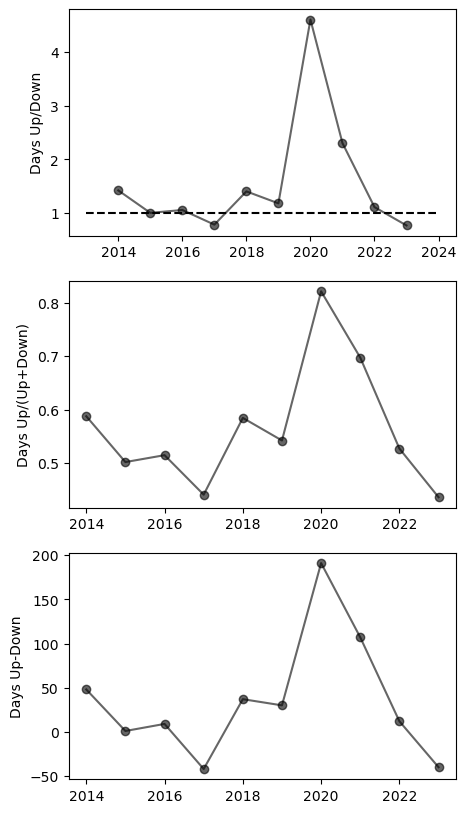

In [30]:
lup = np.array(lup[1:])
ldw = np.array(ldw)

fig, ax = plt.subplots(3,1,figsize=[5,10])

ax[0].plot([2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],lup/ldw, alpha=0.6,c='k',marker='o')
ax[0].set_ylabel('Days Up/Down')
ax[0].plot([2013,2024],[1,1],'k--')

ax[1].plot([2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],lup/(lup+ldw), alpha=0.6,c='k',marker='o')
ax[1].set_ylabel('Days Up/(Up+Down)')
# ax[1].plot([2013,2024],[1,1],'k--')

ax[2].plot([2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],lup-ldw, alpha=0.6,c='k',marker='o')
ax[2].set_ylabel('Days Up-Down')
# ax[2].plot([2013,2024],[1,1],'k--')

In [31]:
all

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,section
1,2.462073e+08,2.464463e+08,2.231439e+08,3.086597e+08,3.027574e+08,2.470653e+08,2.976967e+08,2.951705e+08,3.676508e+08,2.923004e+08,cuc
2,1.975970e+08,2.592791e+08,2.491655e+08,1.760029e+08,1.991930e+08,2.586149e+08,2.462440e+08,1.908299e+08,1.631523e+08,1.553563e+08,offd
3,5.155185e+07,1.100921e+08,6.128392e+07,5.998644e+07,5.533254e+07,4.366710e+07,6.613465e+07,3.755567e+07,8.878156e+07,3.926016e+07,offs
4,1.410987e+08,1.607634e+08,1.324742e+08,1.683593e+08,1.727569e+08,2.081716e+08,1.557370e+08,1.650328e+08,1.350801e+08,1.158886e+08,north
5,1.273339e+08,2.446863e+08,2.106232e+08,2.301166e+08,1.670901e+08,2.114636e+08,1.037570e+08,1.539312e+08,1.954030e+08,1.927002e+08,south
6,9.877364e+07,1.077782e+08,9.401023e+07,1.149861e+08,9.222280e+07,7.507590e+07,6.216470e+07,6.385509e+07,8.427596e+07,8.527073e+07,fresh
7,3.607165e+08,4.646745e+08,4.182435e+08,4.863923e+08,4.066038e+08,4.770674e+08,3.894157e+08,4.280312e+08,4.813814e+08,4.243668e+08,loop


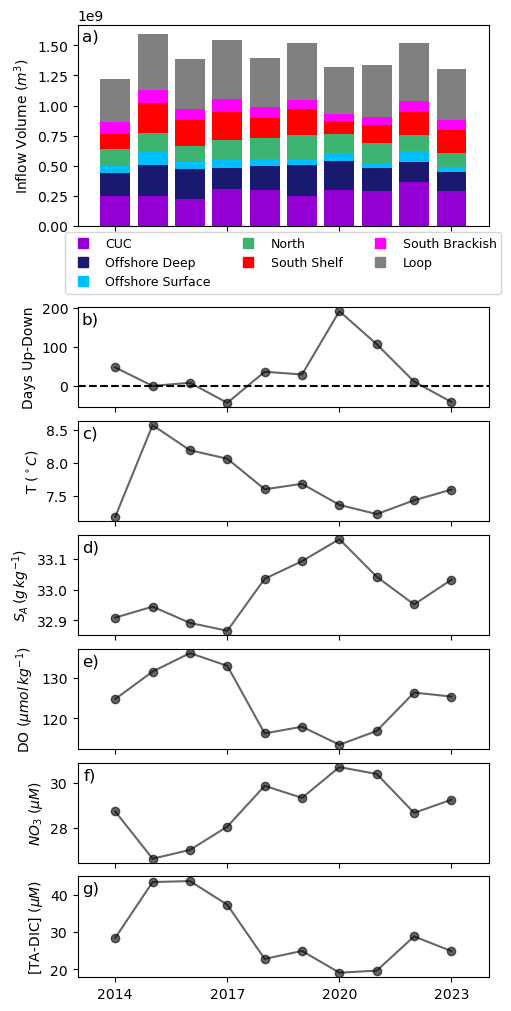

In [32]:
## maybe it makes more sense to plot interannual varriability in watermass inflow with average properties
# Assign colors to each section
colors = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta','grey']

# fig, ax = plt.subplots(8,1,figsize=[5,3*8])
fig = plt.figure(constrained_layout=True, figsize=[5,10])
gs = GridSpec(8, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3,0]) # temp
ax5 = fig.add_subplot(gs[4,0]) # salt
ax6 = fig.add_subplot(gs[5,0]) # DO
ax7 = fig.add_subplot(gs[6,0]) # NO3
ax8 = fig.add_subplot(gs[7,0]) # TA-DIC   

# Plot all 
all_cum_values = np.zeros(len(all.columns[:-1]))
for i in range(len(all)):
    bars = ax1.bar(pd.to_numeric((all.columns[:-1])), all.iloc[i,:-1], bottom=all_cum_values, color=colors[i % len(colors)])
    all_cum_values += all.iloc[i,:-1]
ax1.text(.03, 0.98, 'a)', ha='center', va='top', transform=ax1.transAxes, fontsize=12)
ax1.set_ylabel('Inflow Volume ($m^3$)')


# Customize plot
# axs.set_ylim(0,360000000000)
# axs.set_yticks([0,50000,150000])
# axs.set_yticklabels([0,50,150])
axs.set_ylabel('Inflow Volume [$m^3$]')
for axs in [ax1,ax3,ax4,ax5,ax6,ax7,ax8]:
    axs.set_xlim([2013,2024])
    axs.set_xticks([2014,2017,2020,2023])
for axs in [ax1,ax3,ax4,ax5,ax6,ax7]:
    axs.set_xticklabels([])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South Shelf', 'South Brackish','Loop']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta','grey']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
# ax2.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)
ax1.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

# # year length
# ax3.plot([2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],length[:-1], alpha=0.6,c='k',marker='o')
# ax3.set_ylabel('Length [d]')

# season ratio
ax3.plot(np.arange(2014,2024,1),lup-ldw, alpha=0.6,c='k',marker='o')
ax3.set_ylabel('Days Up-Down')
ax3.plot([2013,2024],[0,0],'k--')
ax3.text(.03, 0.95, 'b)', ha='center', va='top', transform=ax3.transAxes, fontsize=12)

# temperature
ax4.plot(np.arange(2014,2024,1),temp, alpha=0.6,c='k',marker='o')
ax4.set_ylabel('T ($^\circ C$)')
# ax4.plot([2013,2024],[0,0],'k--')
ax4.text(.03, 0.95, 'c)', ha='center', va='top', transform=ax4.transAxes, fontsize=12)

#salt
ax5.plot(np.arange(2014,2024,1),salt, alpha=0.6,c='k',marker='o')
ax5.set_ylabel('$S_A \,(g\,kg^{-1}$)')
# ax5.plot([2013,2024],[0,0],'k--')
ax5.text(.03, 0.95, 'd)', ha='center', va='top', transform=ax5.transAxes, fontsize=12)

# DO
ax6.plot(np.arange(2014,2024,1),DO, alpha=0.6,c='k',marker='o')
ax6.set_ylabel('DO ($\mu mol \, kg^{-1}$)')
# ax6.plot([2013,2024],[0,0],'k--')
ax6.text(.03, 0.95, 'e)', ha='center', va='top', transform=ax6.transAxes, fontsize=12)

# NO3
ax7.plot(np.arange(2014,2024,1),NO3, alpha=0.6,c='k',marker='o')
ax7.set_ylabel('$NO_3$ ($\mu M$)')
# ax7.plot([2013,2024],[0,0],'k--')
ax7.text(.03, 0.95, 'f)', ha='center', va='top', transform=ax7.transAxes, fontsize=12)

# TA-DIC
ax8.plot(np.arange(2014,2024,1),TADIC, alpha=0.6,c='k',marker='o')
ax8.set_ylabel('[TA-DIC] ($\mu M$)')
# ax8.plot([2013,2024],[0,0],'k--')
ax8.text(.03, 0.95, 'g)', ha='center', va='top', transform=ax8.transAxes, fontsize=12)

plt.savefig('/data1/bbeutel/LO_user/ariane/figures/volumebar.jpg')


In [33]:
all

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,section
1,2.462073e+08,2.464463e+08,2.231439e+08,3.086597e+08,3.027574e+08,2.470653e+08,2.976967e+08,2.951705e+08,3.676508e+08,2.923004e+08,cuc
2,1.975970e+08,2.592791e+08,2.491655e+08,1.760029e+08,1.991930e+08,2.586149e+08,2.462440e+08,1.908299e+08,1.631523e+08,1.553563e+08,offd
3,5.155185e+07,1.100921e+08,6.128392e+07,5.998644e+07,5.533254e+07,4.366710e+07,6.613465e+07,3.755567e+07,8.878156e+07,3.926016e+07,offs
4,1.410987e+08,1.607634e+08,1.324742e+08,1.683593e+08,1.727569e+08,2.081716e+08,1.557370e+08,1.650328e+08,1.350801e+08,1.158886e+08,north
5,1.273339e+08,2.446863e+08,2.106232e+08,2.301166e+08,1.670901e+08,2.114636e+08,1.037570e+08,1.539312e+08,1.954030e+08,1.927002e+08,south
6,9.877364e+07,1.077782e+08,9.401023e+07,1.149861e+08,9.222280e+07,7.507590e+07,6.216470e+07,6.385509e+07,8.427596e+07,8.527073e+07,fresh
7,3.607165e+08,4.646745e+08,4.182435e+08,4.863923e+08,4.066038e+08,4.770674e+08,3.894157e+08,4.280312e+08,4.813814e+08,4.243668e+08,loop


In [34]:
# print annual mean inflow volume from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.mean(all.iloc[i,:-1]),'(',np.std(all.iloc[i,:-1]),') m3')

print('\n')
# print annual mean inflow percentage from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.round(np.mean(all.iloc[i,:-1]/np.sum(all.iloc[:,:-1],axis=0)),3)*100,' %')

print('\n')
# print annual mean inflow percentage from each watermass without loop included
for i in range(len(all)-1):
    print(all.section[i+1],'= ',np.round(np.mean(all.iloc[i,:-1]/np.sum(all.iloc[:-1,:-1],axis=0)),3)*100,' %')

cuc =  282709831.3183142 ( 40284287.58704831 ) m3
offd =  209543503.12620655 ( 38225483.380166665 ) m3
offs =  61364604.096710086 ( 21568657.902401093 ) m3
north =  155536248.95541143 ( 24657067.397870835 ) m3
south =  183710508.7856233 ( 42799019.6106439 ) m3
fresh =  87841333.8962766 ( 16516629.576826477 ) m3
loop =  433689333.48135424 ( 40336327.269907266 ) m3


cuc =  20.1  %
offd =  14.899999999999999  %
offs =  4.3  %
north =  11.0  %
south =  12.9  %
fresh =  6.2  %
loop =  30.7  %


cuc =  28.999999999999996  %
offd =  21.4  %
offs =  6.2  %
north =  15.9  %
south =  18.6  %
fresh =  9.0  %


In [35]:
# print upwelling mean inflow volume from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.mean(up.iloc[i,1:]),' m3')

print('\n')
# print upwelling mean inflow percentage from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.round(np.mean(up.iloc[i,1:]/np.sum(up.iloc[:,1:],axis=0)),3)*100,' %')

cuc =  6737156.447442924  m3
offd =  6601797.168354499  m3
offs =  1265448.9931746454  m3
north =  5529095.03768028  m3
south =  976458.5180611968  m3
fresh =  211283.20152535714  m3
loop =  7337206.447959483  m3


cuc =  23.799999999999997  %
offd =  22.8  %
offs =  4.5  %
north =  19.400000000000002  %
south =  3.4000000000000004  %
fresh =  0.7000000000000001  %
loop =  25.4  %


In [36]:
# print downwelling mean inflow volume from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.mean(dw.iloc[i,:]),' m3')

print('\n')
# print downwelling mean inflow percentage from each watermass
for i in range(len(all)):
    print(all.section[i+1],'= ',np.round(np.mean(dw.iloc[i,:]/np.sum(dw.iloc[:,:],axis=0)),3)*100,' %')

cuc =  2671836.033586351  m3
offd =  622709.5387346759  m3
offs =  571195.5454219184  m3
north =  197999.62853191356  m3
south =  4797785.235486201  m3
fresh =  2985310.3147340138  m3
loop =  7242081.069504087  m3


cuc =  14.000000000000002  %
offd =  3.0  %
offs =  2.7  %
north =  1.3  %
south =  24.3  %
fresh =  16.6  %
loop =  38.0  %


In [37]:
from scipy.stats import pearsonr

In [38]:
# correlation with length of upweling and downwelling to volume from each watermass

# first with length of upwelling
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(lup,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# significant negative correlation with freshwater inflow (alpha=0.1)

PearsonRResult(statistic=-0.2458083204647851, pvalue=0.49362252337753204)
PearsonRResult(statistic=0.5174315803612028, pvalue=0.1255850067497664)
PearsonRResult(statistic=-0.27549958275395703, pvalue=0.4410407881733459)
PearsonRResult(statistic=0.36566663835433727, pvalue=0.29875237835310453)
PearsonRResult(statistic=-0.5336765295238198, pvalue=0.11210996014008731)
PearsonRResult(statistic=-0.6177056540388675, pvalue=0.05703409718641946)
PearsonRResult(statistic=-0.2900703152113016, pvalue=0.4162195836205868)


In [39]:
# length of downwelling
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# significant positive correlation with south inflow (alpha=0.01)
# significant positive correlation with fresh inflow (alpha=0.1)

PearsonRResult(statistic=-0.2628890374051897, pvalue=0.4630527748814674)
PearsonRResult(statistic=-0.11511732917291304, pvalue=0.7514914994925778)
PearsonRResult(statistic=-0.06074770323977165, pvalue=0.8676036998534195)
PearsonRResult(statistic=0.002688872716589241, pvalue=0.9941181334586937)
PearsonRResult(statistic=0.7883349157398548, pvalue=0.006741879266925218)
PearsonRResult(statistic=0.6318655248891941, pvalue=0.050014861899901564)
PearsonRResult(statistic=0.5398917567715724, pvalue=0.10720542797644435)


In [40]:
# difference
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(lup-ldw,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# significant negaitve correlation with south inflow (alpha=0.01)
# significant negative correlation with fresh inflow (alpha=0.1)

PearsonRResult(statistic=0.04094383012271603, pvalue=0.9105853665388489)
PearsonRResult(statistic=0.3544206663736996, pvalue=0.31497228230541385)
PearsonRResult(statistic=-0.10827027280167932, pvalue=0.7659156651487501)
PearsonRResult(statistic=0.19507595106135578, pvalue=0.5891429343356044)
PearsonRResult(statistic=-0.8068806240042069, pvalue=0.004785412150818858)
PearsonRResult(statistic=-0.7489874453387586, pvalue=0.012664323985038237)
PearsonRResult(statistic=-0.5119930182351852, pvalue=0.13031023067550032)


In [41]:
# what about comparison to the strength of upwelling and downwelling?
# basing this on the Bakun index at 45

bak48 = pd.read_csv('/data1/bbeutel/LO_user/Bakun.txt', sep="\s+", header=5)
bak48['date'] = pd.to_datetime(bak48.YYYYMMDD, format='%Y%m%d', errors='coerce')
bak48 = bak48.sort_values(by='date')
# drop values greater than -500
bak48.loc[bak48.Index<=-500, "Index"] = 0

# come up with a function to identify the strength of upwelling (take annual peak) and downwelling (take annual trough)
bak48['year'] = [bak48.date[i].year for i in range(len(bak48))]
bak48 = bak48[(bak48.year >= 2014) & (bak48.year <= 2023)] #drop years we're not working with

peak = np.empty(len(set(bak48.year)),dtype='float')
trough = np.empty(len(set(bak48.year)),dtype='float')
i=0
for year in set(bak48.year):
    data = bak48.Index[bak48.year == year]

    peak[i] = np.max(data)
    trough[i] = np.min(data)
    i+=1

In [42]:
# first with strength of upwelling
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(peak,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# north water correlated to the strength of upwelling! 
# NOTE i orriginally tried this with the Bakun index at 45 and it was not correlated, correlation only appeared with the bakun index at 48

PearsonRResult(statistic=-0.3936143398491037, pvalue=0.26042669144375147)
PearsonRResult(statistic=0.32708683890430174, pvalue=0.3562575424634095)
PearsonRResult(statistic=-0.38924290979600285, pvalue=0.2662328418523788)
PearsonRResult(statistic=0.7254978767959106, pvalue=0.017557181621224355)
PearsonRResult(statistic=0.08587035445185114, pvalue=0.8135375719122797)
PearsonRResult(statistic=-0.21446696029305948, pvalue=0.5518434169057869)
PearsonRResult(statistic=0.16019817231192734, pvalue=0.6584221984164291)


In [43]:
# first with strength of downwelling
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='cuc'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offd'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='offs'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='north'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='south'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='fresh'].values[0]))
print(pearsonr(trough,all[["2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]][all.section=='loop'].values[0]))

# not a single significant correlation

PearsonRResult(statistic=0.32294032920587074, pvalue=0.36274651201692365)
PearsonRResult(statistic=-0.21816153361239582, pvalue=0.5448437989273797)
PearsonRResult(statistic=-0.08127103181576559, pvalue=0.823389207714646)
PearsonRResult(statistic=-0.271716716203073, pvalue=0.447593005956941)
PearsonRResult(statistic=0.003263890032456503, pvalue=0.9928603166132167)
PearsonRResult(statistic=-0.19778288174610562, pvalue=0.5838808495707503)
PearsonRResult(statistic=-0.008696565514904964, pvalue=0.9809777016408814)


In [44]:
# corellation of length of downwelling to the tracers
measure = ldw
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=-0.5259360893045054, pvalue=0.11841167183087918)
PearsonRResult(statistic=0.5786822759991439, pvalue=0.07965588562166787)
PearsonRResult(statistic=0.6773656948921704, pvalue=0.031404885633621905)
PearsonRResult(statistic=-0.6000359994630771, pvalue=0.06666735855796728)
PearsonRResult(statistic=0.5794531753828303, pvalue=0.0791606808645602)


In [45]:
# corellation of length of upwelling to the tracers
measure = lup
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=0.6182714273163482, pvalue=0.05674185287109749)
PearsonRResult(statistic=-0.27668139669497027, pvalue=0.4390028344268154)
PearsonRResult(statistic=-0.5168819344419009, pvalue=0.126057658130722)
PearsonRResult(statistic=0.494639659091988, pvalue=0.14611317488099684)
PearsonRResult(statistic=-0.4009115205685966, pvalue=0.2508917163359361)


In [46]:
# corellation of length of upweling-downwelling to the tracers
measure = lup-ldw
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

# overall strongest correlations here
# salt, DO, NO3, TA-DIC correlated to lup-ldw at alpha=0.1

PearsonRResult(statistic=0.6794743731537884, pvalue=0.03067956595915429)
PearsonRResult(statistic=-0.5303520709037259, pvalue=0.11479009203822663)
PearsonRResult(statistic=-0.7247002979552605, pvalue=0.017743258694631562)
PearsonRResult(statistic=0.661759008237307, pvalue=0.037138693379409685)
PearsonRResult(statistic=-0.5977365807692705, pvalue=0.06799421055123049)


In [47]:
# correlation to salt
measure = salt
# print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=-0.4484175745957346, pvalue=0.19366979422367742)
PearsonRResult(statistic=-0.8788913384042051, pvalue=0.0008111923646917464)
PearsonRResult(statistic=0.7875946913655986, pvalue=0.006830108617230145)
PearsonRResult(statistic=-0.7844868239026902, pvalue=0.0072095046673363375)


In [48]:
# correlation to temp
measure = temp
print(pearsonr(measure,salt))
# print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=-0.4484175745957346, pvalue=0.19366979422367742)
PearsonRResult(statistic=0.7072196185794338, pvalue=0.02217306493418018)
PearsonRResult(statistic=-0.8299614520798888, pvalue=0.002962677152434954)
PearsonRResult(statistic=0.8653256182136296, pvalue=0.0012194035864178136)


In [49]:
# corellation upweling strength to the tracers
measure = peak
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=0.3740652195369187, pvalue=0.2869360155234492)
PearsonRResult(statistic=-0.09338549066161299, pvalue=0.7974914386528733)
PearsonRResult(statistic=-0.3928878127755102, pvalue=0.26138678830894285)
PearsonRResult(statistic=0.2253579615955945, pvalue=0.5313118963516218)
PearsonRResult(statistic=-0.28270456551934525, pvalue=0.428683763934357)


In [50]:
# corellation downwelling strength to the tracers
measure = peak
print(pearsonr(measure,salt))
print(pearsonr(measure,temp))
print(pearsonr(measure,DO))
print(pearsonr(measure,NO3))
print(pearsonr(measure,TADIC))

PearsonRResult(statistic=0.3740652195369187, pvalue=0.2869360155234492)
PearsonRResult(statistic=-0.09338549066161299, pvalue=0.7974914386528733)
PearsonRResult(statistic=-0.3928878127755102, pvalue=0.26138678830894285)
PearsonRResult(statistic=0.2253579615955945, pvalue=0.5313118963516218)
PearsonRResult(statistic=-0.28270456551934525, pvalue=0.428683763934357)


In [51]:
#plot in fractions instead

d = {'2014':all14.transport[1:]/np.sum(all14.transport[1:]),'2015':all15.transport[1:]/np.sum(all15.transport[1:]),
     '2016':all16.transport[1:]/np.sum(all16.transport[1:]),'2017':all17.transport[1:]/np.sum(all17.transport[1:]),'2018':all18.transport[1:]/np.sum(all18.transport[1:]),
     '2019':all19.transport[1:]/np.sum(all19.transport[1:]),'2020':all20.transport[1:]/np.sum(all20.transport[1:]),'2021':all21.transport[1:]/np.sum(all21.transport[1:]),
     '2022':all22.transport[1:]/np.sum(all22.transport[1:]),'2023':all23.transport[1:]/np.sum(all23.transport[1:])}
allfrac = pd.DataFrame(d)

Text(0.03, 0.95, 'b)')

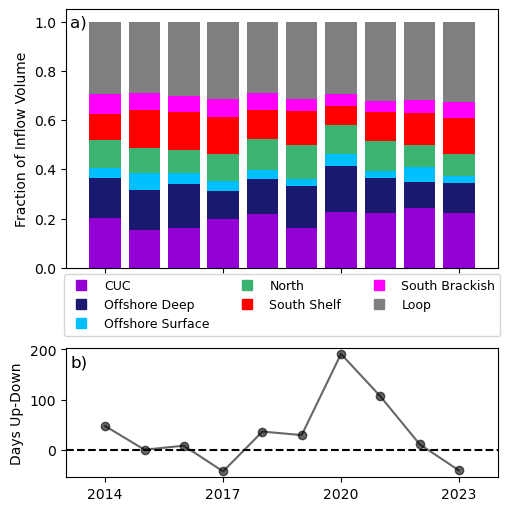

In [52]:
## maybe it makes more sense to plot interannual varriability in watermass inflow with average properties
# Assign colors to each section
colors = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta','grey']

# fig, ax = plt.subplots(8,1,figsize=[5,3*8])
fig = plt.figure(constrained_layout=True, figsize=[5,5])
gs = GridSpec(3, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax3 = fig.add_subplot(gs[2, 0])
# ax4 = fig.add_subplot(gs[3,0])

# Plot all 
all_cum_values = np.zeros(len(allfrac.columns))
for i in range(len(allfrac)):
    bars = ax1.bar(pd.to_numeric((allfrac.columns)), allfrac.iloc[i,:], bottom=all_cum_values, color=colors[i % len(colors)])
    all_cum_values += allfrac.iloc[i,:]
ax1.text(.03, 0.98, 'a)', ha='center', va='top', transform=ax1.transAxes, fontsize=12)
ax1.set_ylabel('Fraction of Inflow Volume')

# Customize plot
# axs.set_ylim(0,360000000000)
# axs.set_yticks([0,50000,150000])
# axs.set_yticklabels([0,50,150])
axs.set_ylabel('Inflow Volume [$m^3$]')
for axs in [ax1,ax3]:
    axs.set_xlim([2013,2024])
    axs.set_xticks([2014,2017,2020,2023])
for axs in [ax1]:
    axs.set_xticklabels([])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South Shelf', 'South Brackish','Loop']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta','grey']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
# ax2.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)
ax1.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

# # year length
# ax3.plot([2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],length[:-1], alpha=0.6,c='k',marker='o')
# ax3.set_ylabel('Length [d]')

# season ratio
ax3.plot([2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],lup-ldw, alpha=0.6,c='k',marker='o')
ax3.set_ylabel('Days Up-Down')
ax3.plot([2013,2024],[0,0],'k--')
ax3.text(.03, 0.95, 'b)', ha='center', va='top', transform=ax3.transAxes, fontsize=12)


combine downwelling and upwelling into one year (downwelling preceding upwelling counting as the upwelling year)

In [53]:
# add [TA-DIC] column
files = [all14,all15,all16,all17,all18,all19,all20,all21,all22,all23]

for file in files:
    file['TA-DIC'] = file.TA - file.DIC

In [54]:
lcom = [113+161+19+18,143+144+60+46,149+158+19+19,198+156+19+20,
        91+128+88+48,163+193+19+29,53+244+19+25,82+189+42+21,
        105+117+137+20,176+136+19+20]

In [55]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([all14.transport*lcom[0],all15.transport*lcom[1],all16.transport*lcom[2],all17.transport*lcom[3],all18.transport*lcom[4],
                          all19.transport*lcom[5],all20.transport*lcom[6],all21.transport*lcom[7],all22.transport*lcom[8],all23.transport*lcom[9]],axis=0),
     'salt':np.mean([all14.salt,all15.salt,all16.salt,all17.salt,all18.salt,all19.salt,all20.salt,all21.salt,all22.salt,all23.salt],axis=0),
     'temp':np.mean([all14.temp,all15.temp,all16.temp,all17.temp,all18.temp,all19.temp,all20.temp,all21.temp,all22.temp,all23.temp],axis=0),
     'DO':np.mean([all14.DO,all15.DO,all16.DO,all17.DO,all18.DO,all19.DO,all20.DO,all21.DO,all22.DO,all23.DO],axis=0),
     'NO3':np.mean([all14.NO3,all15.NO3,all16.NO3,all17.NO3,all18.NO3,all19.NO3,all20.NO3,all21.NO3,all22.NO3,all23.NO3],axis=0),
     'TA':np.mean([all14.TA,all15.TA,all16.TA,all17.TA,all18.TA,all19.TA,all20.TA,all21.TA,all22.TA,all23.TA],axis=0),
     'DIC':np.mean([all14.DIC,all15.DIC,all16.DIC,all17.DIC,all18.DIC,all19.DIC,all20.DIC,all21.DIC,all22.DIC,all23.DIC],axis=0),
     'TA-DIC':np.mean([all14['[TA-DIC]'],all15['[TA-DIC]'],all16['[TA-DIC]'],all17['[TA-DIC]'],all18['[TA-DIC]'],all19['[TA-DIC]'],all20['[TA-DIC]'],all21['[TA-DIC]'],all22['[TA-DIC]'],all23['[TA-DIC]']],axis=0)}
all_b = pd.DataFrame(d)

all_b

,section,transport,salt,temp,DO,NO3,TA,DIC,TA-DIC
0,salish,5.131816e+11,32.992956,7.690263,124.157593,28.861600,2276.186625,2246.839051,29.347574
1,cuc,1.021044e+11,33.844661,6.519460,66.533519,36.526207,2320.085505,2320.881654,-0.796148
2,off_d,7.577457e+10,33.734220,6.686667,89.369098,33.650884,2312.313263,2296.522275,15.790988
3,off_s,2.238251e+10,32.835558,8.832818,215.770443,15.595599,2266.865717,2153.315142,113.550575
4,north,5.644600e+10,33.218864,7.637437,154.908330,23.989951,2284.711811,2221.949007,62.762804
5,south,6.721013e+10,32.864380,9.404059,200.422824,17.840091,2270.520067,2171.151849,99.368218
6,fresh,3.181646e+10,30.039493,10.071364,292.972139,7.480471,2160.307036,1988.168208,172.138828
7,loop,1.574475e+11,32.012657,8.525796,173.457623,27.562427,2228.227657,2183.958451,44.269206


In [56]:
all14.transport = all14.transport*lcom[0]
all15.transport = all15.transport*lcom[1]
all16.transport = all16.transport*lcom[2]
all17.transport = all17.transport*lcom[3]
all18.transport = all18.transport*lcom[4]
all19.transport = all19.transport*lcom[5]
all20.transport = all20.transport*lcom[6]
all21.transport = all21.transport*lcom[7]
all22.transport = all22.transport*lcom[8]
all23.transport = all23.transport*lcom[9]

In [57]:
# math! 
math_all14 = decomp(all14,all_b)[1:]
math_all15 = decomp(all15,all_b)[1:]
math_all16 = decomp(all16,all_b)[1:]
math_all17 = decomp(all17,all_b)[1:]
math_all18 = decomp(all18,all_b)[1:]
math_all19 = decomp(all19,all_b)[1:]
math_all20 = decomp(all20,all_b)[1:]
math_all21 = decomp(all21,all_b)[1:]
math_all22 = decomp(all22,all_b)[1:]
math_all23 = decomp(all23,all_b)[1:]


# add year 
math_all14['year'] = 2014
math_all15['year'] = 2015
math_all16['year'] = 2016
math_all17['year'] = 2017
math_all18['year'] = 2018
math_all19['year'] = 2019
math_all20['year'] = 2020
math_all21['year'] = 2021
math_all22['year'] = 2022
math_all23['year'] = 2023


### plotting

/tmp/ipykernel_197590/819159033.py:161: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


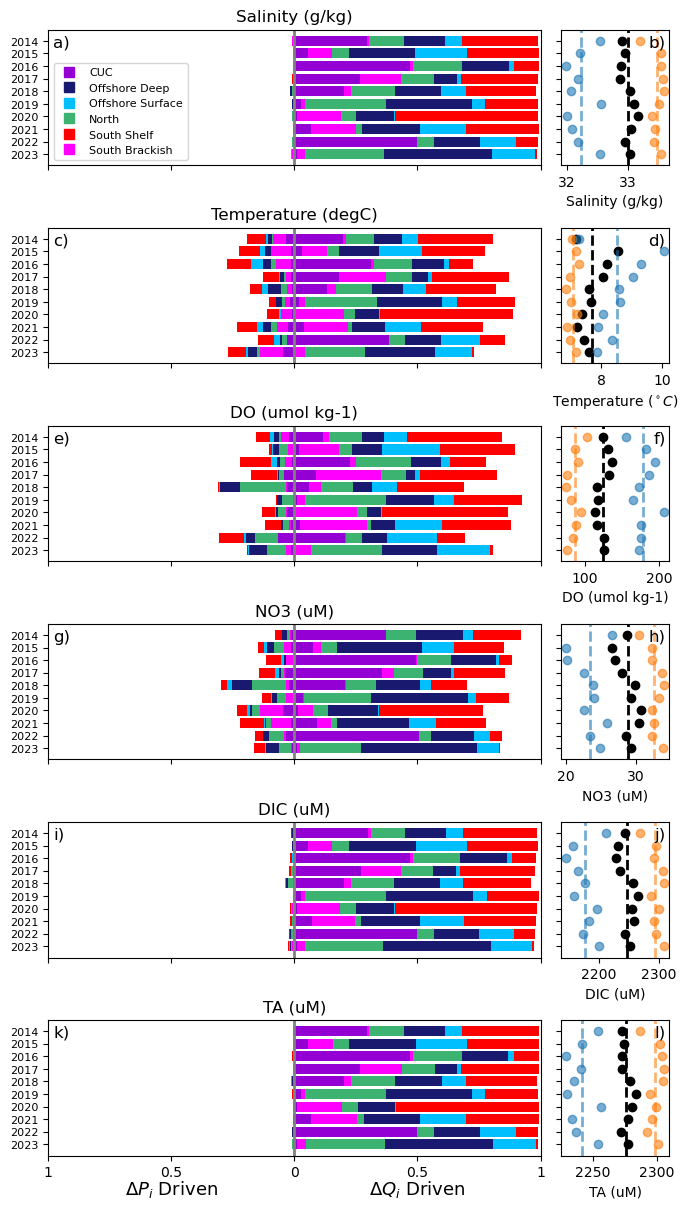

In [58]:
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[7,2*6])
gs = GridSpec(6, 5, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])
ax3 = fig.add_subplot(gs[1, :4])
ax4 = fig.add_subplot(gs[1, 4])
ax5 = fig.add_subplot(gs[2, :4])
ax6 = fig.add_subplot(gs[2, 4])
ax7 = fig.add_subplot(gs[3, :4])
ax8 = fig.add_subplot(gs[3, 4])
ax9 = fig.add_subplot(gs[4, :4])
ax10 = fig.add_subplot(gs[4, 4])
ax11 = fig.add_subplot(gs[5, :4])
ax12 = fig.add_subplot(gs[5, 4])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ']][:-1],math_all15[['year','section','saltP','saltQ']][:-1],
    math_all16[['year','section','saltP','saltQ']][:-1],math_all17[['year','section','saltP','saltQ']][:-1],
    math_all18[['year','section','saltP','saltQ']][:-1],math_all19[['year','section','saltP','saltQ']][:-1],
    math_all20[['year','section','saltP','saltQ']][:-1],math_all21[['year','section','saltP','saltQ']][:-1],
    math_all22[['year','section','saltP','saltQ']][:-1],math_all23[['year','section','saltP','saltQ']][:-1]])
combined_stacked_bar(df,'Salinity (g/kg)',ax1,ax2)

# mean property inflow to JdF
ax2.scatter([all14.salt[0],all15.salt[0],all16.salt[0],all17.salt[0],all18.salt[0],all19.salt[0],all20.salt[0],all21.salt[0],all22.salt[0],all23.salt[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],c='k')
ax2.scatter([up14.salt[0],up15.salt[0],up16.salt[0],up17.salt[0],up18.salt[0],up19.salt[0],up20.salt[0],up21.salt[0],up22.salt[0],up23.salt[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:orange')
ax2.scatter([dw13.salt[0],dw14.salt[0],dw15.salt[0],dw16.salt[0],dw17.salt[0],dw18.salt[0],dw19.salt[0],dw20.salt[0],dw21.salt[0],dw22.salt[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:blue')
ax2.axvline(all_b.salt[0], color='k', ls='dashed', linewidth=2)
ax2.axvline(up_b.salt[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax2.axvline(dw_b.salt[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax2.set_xlabel('Salinity (g/kg)',fontsize=10)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ']][:-1],math_all15[['year','section','tempP','tempQ']][:-1],
    math_all16[['year','section','tempP','tempQ']][:-1],math_all17[['year','section','tempP','tempQ']][:-1],
    math_all18[['year','section','tempP','tempQ']][:-1],math_all19[['year','section','tempP','tempQ']][:-1],
    math_all20[['year','section','tempP','tempQ']][:-1],math_all21[['year','section','tempP','tempQ']][:-1],
    math_all22[['year','section','tempP','tempQ']][:-1],math_all23[['year','section','tempP','tempQ']][:-1]])
combined_stacked_bar(df,'Temperature (degC)',ax3,ax4)

# mean property inflow to JdF
ax4.scatter([all14.temp[0],all15.temp[0],all16.temp[0],all17.temp[0],all18.temp[0],all19.temp[0],all20.temp[0],all21.temp[0],all22.temp[0],all23.temp[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],c='k')
ax4.scatter([up14.temp[0],up15.temp[0],up16.temp[0],up17.temp[0],up18.temp[0],up19.temp[0],up20.temp[0],up21.temp[0],up22.temp[0],up23.temp[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:orange')
ax4.scatter([dw13.temp[0],dw14.temp[0],dw15.temp[0],dw16.temp[0],dw17.temp[0],dw18.temp[0],dw19.temp[0],dw20.temp[0],dw21.temp[0],dw22.temp[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:blue')
ax4.axvline(all_b.temp[0], color='k', ls='dashed', linewidth=2)
ax4.axvline(up_b.temp[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax4.axvline(dw_b.temp[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax4.set_xlabel('Temperature ($^\circ C$)',fontsize=10)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ']][:-1],math_all15[['year','section','DOP','DOQ']][:-1],
    math_all16[['year','section','DOP','DOQ']][:-1],math_all17[['year','section','DOP','DOQ']][:-1],
    math_all18[['year','section','DOP','DOQ']][:-1],math_all19[['year','section','DOP','DOQ']][:-1],
    math_all20[['year','section','DOP','DOQ']][:-1],math_all21[['year','section','DOP','DOQ']][:-1],
    math_all22[['year','section','DOP','DOQ']][:-1],math_all23[['year','section','DOP','DOQ']][:-1]])
combined_stacked_bar(df,'DO (umol kg-1)',ax5,ax6)

# mean property inflow to JdF
ax6.scatter([all14.DO[0],all15.DO[0],all16.DO[0],all17.DO[0],all18.DO[0],all19.DO[0],all20.DO[0],all21.DO[0],all22.DO[0],all23.DO[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],c='k')
ax6.scatter([up14.DO[0],up15.DO[0],up16.DO[0],up17.DO[0],up18.DO[0],up19.DO[0],up20.DO[0],up21.DO[0],up22.DO[0],up23.DO[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:orange')
ax6.scatter([dw13.DO[0],dw14.DO[0],dw15.DO[0],dw16.DO[0],dw17.DO[0],dw18.DO[0],dw19.DO[0],dw20.DO[0],dw21.DO[0],dw22.DO[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:blue')
ax6.axvline(all_b.DO[0], color='k', ls='dashed', linewidth=2)
ax6.axvline(up_b.DO[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax6.axvline(dw_b.DO[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax6.set_xlabel('DO (umol kg-1)',fontsize=10)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q']][:-1],math_all15[['year','section','NO3P','NO3Q']][:-1],
    math_all16[['year','section','NO3P','NO3Q']][:-1],math_all17[['year','section','NO3P','NO3Q']][:-1],
    math_all18[['year','section','NO3P','NO3Q']][:-1],math_all19[['year','section','NO3P','NO3Q']][:-1],
    math_all20[['year','section','NO3P','NO3Q']][:-1],math_all21[['year','section','NO3P','NO3Q']][:-1],
    math_all22[['year','section','NO3P','NO3Q']][:-1],math_all23[['year','section','NO3P','NO3Q']][:-1]])
combined_stacked_bar(df,'NO3 (uM)',ax7,ax8)

# mean property inflow to JdF
ax8.scatter([all14.NO3[0],all15.NO3[0],all16.NO3[0],all17.NO3[0],all18.NO3[0],all19.NO3[0],all20.NO3[0],all21.NO3[0],all22.NO3[0],all23.NO3[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],c='k')
ax8.scatter([up14.NO3[0],up15.NO3[0],up16.NO3[0],up17.NO3[0],up18.NO3[0],up19.NO3[0],up20.NO3[0],up21.NO3[0],up22.NO3[0],up23.NO3[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:orange')
ax8.scatter([dw13.NO3[0],dw14.NO3[0],dw15.NO3[0],dw16.NO3[0],dw17.NO3[0],dw18.NO3[0],dw19.NO3[0],dw20.NO3[0],dw21.NO3[0],dw22.NO3[0]], [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],alpha=0.6,c='tab:blue')
ax8.axvline(all_b.NO3[0], color='k', ls='dashed', linewidth=2)
ax8.axvline(up_b.NO3[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax8.axvline(dw_b.NO3[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax8.set_xlabel('NO3 (uM)',fontsize=10)

# DIC
df = pd.concat([math_all14[['year','section','DICP','DICQ']][:-1],math_all15[['year','section','DICP','DICQ']][:-1],
    math_all16[['year','section','DICP','DICQ']][:-1],math_all17[['year','section','DICP','DICQ']][:-1],
    math_all18[['year','section','DICP','DICQ']][:-1],math_all19[['year','section','DICP','DICQ']][:-1],
    math_all20[['year','section','DICP','DICQ']][:-1],math_all21[['year','section','DICP','DICQ']][:-1],
    math_all22[['year','section','DICP','DICQ']][:-1],math_all23[['year','section','DICP','DICQ']][:-1]])
combined_stacked_bar(df,'DIC (uM)',ax9,ax10)

# mean property inflow to JdF
ax10.scatter([all14.DIC[0],all15.DIC[0],all16.DIC[0],all17.DIC[0],all18.DIC[0],all19.DIC[0],all20.DIC[0],all21.DIC[0],all22.DIC[0],all23.DIC[0]], [2014,2015,2016,2017,2018,2020,2019,2021,2022,2023],c='k')
ax10.scatter([up14.DIC[0],up15.DIC[0],up16.DIC[0],up17.DIC[0],up18.DIC[0],up19.DIC[0],up20.DIC[0],up21.DIC[0],up22.DIC[0],up23.DIC[0]], [2014,2015,2016,2017,2018,2020,2019,2021,2022,2023],alpha=0.6,c='tab:orange')
ax10.scatter([dw13.DIC[0],dw14.DIC[0],dw15.DIC[0],dw16.DIC[0],dw17.DIC[0],dw18.DIC[0],dw19.DIC[0],dw20.DIC[0],dw21.DIC[0],dw22.DIC[0]], [2014,2015,2016,2017,2018,2020,2019,2021,2022,2023],alpha=0.6,c='tab:blue')
ax10.axvline(all_b.DIC[0], color='k', ls='dashed', linewidth=2)
ax10.axvline(up_b.DIC[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax10.axvline(dw_b.DIC[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax10.set_xlabel('DIC (uM)',fontsize=10)

# TA
df = pd.concat([math_all14[['year','section','TAP','TAQ']][:-1],math_all15[['year','section','TAP','TAQ']][:-1],
    math_all16[['year','section','TAP','TAQ']][:-1],math_all17[['year','section','TAP','TAQ']][:-1],
    math_all18[['year','section','TAP','TAQ']][:-1],math_all19[['year','section','TAP','TAQ']][:-1],
    math_all20[['year','section','TAP','TAQ']][:-1],math_all21[['year','section','TAP','TAQ']][:-1],
    math_all22[['year','section','TAP','TAQ']][:-1],math_all23[['year','section','TAP','TAQ']][:-1]])
combined_stacked_bar(df,'TA (uM)',ax11,ax12)

# mean property inflow to JdF
ax12.scatter([all14.TA[0],all15.TA[0],all16.TA[0],all17.TA[0],all18.TA[0],all19.TA[0],all20.TA[0],all21.TA[0],all22.TA[0],all23.TA[0]], [2014,2015,2016,2017,2018,2020,2019,2021,2022,2023],c='k')
ax12.scatter([up14.TA[0],up15.TA[0],up16.TA[0],up17.TA[0],up18.TA[0],up19.TA[0],up20.TA[0],up21.TA[0],up22.TA[0],up23.TA[0]], [2014,2015,2016,2017,2018,2020,2019,2021,2022,2023],alpha=0.6,c='tab:orange')
ax12.scatter([dw13.TA[0],dw14.TA[0],dw15.TA[0],dw16.TA[0],dw17.TA[0],dw18.TA[0],dw19.TA[0],dw20.TA[0],dw21.TA[0],dw22.TA[0]], [2014,2015,2016,2017,2018,2020,2019,2021,2022,2023],alpha=0.6,c='tab:blue')
ax12.axvline(all_b.TA[0], color='k', ls='dashed', linewidth=2)
ax12.axvline(up_b.TA[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax12.axvline(dw_b.TA[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax12.set_xlabel('TA (uM)',fontsize=10)

ax11.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=12)
ax3.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=12)
ax5.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=12)
ax7.text(.01, .85, 'g)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=12)
ax9.text(.01, .85, 'i)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=12)
ax11.text(.01, .85, 'k)', ha='left', va='bottom', transform=ax11.transAxes, fontsize=12)
ax2.text(.97, .85, 'b)', ha='right', va='bottom', transform=ax2.transAxes, fontsize=12)
ax4.text(.97, .85, 'd)', ha='right', va='bottom', transform=ax4.transAxes, fontsize=12)
ax6.text(.97, .85, 'f)', ha='right', va='bottom', transform=ax6.transAxes, fontsize=12)
ax8.text(.97, .85, 'h)', ha='right', va='bottom', transform=ax8.transAxes, fontsize=12)
ax10.text(.97, .85, 'j)', ha='right', va='bottom', transform=ax10.transAxes, fontsize=12)
ax12.text(.97, .85, 'l)', ha='right', va='bottom', transform=ax12.transAxes, fontsize=12)

ax11.text(.25, -0.32, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax11.transAxes, fontsize=13)
ax11.text(.75, -0.32, r'$\Delta Q_i$ Driven', ha='center', va='bottom', transform=ax11.transAxes, fontsize=13)

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South Shelf', 'South Brackish']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)
# fig.legend(handles=legend_handles, loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.001), frameon=True,fontsize=9)


# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/attribution.pdf")

/tmp/ipykernel_197590/819159033.py:161: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


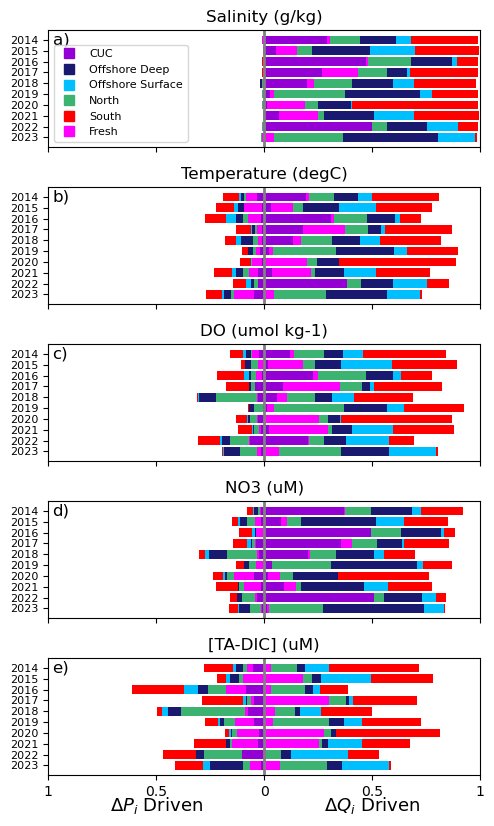

In [ ]:
# without subfigures to the right
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[5,8])
gs = GridSpec(5, 1, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[3,0])
ax9 = fig.add_subplot(gs[4,0])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ']][:-1],math_all15[['year','section','saltP','saltQ']][:-1],
    math_all16[['year','section','saltP','saltQ']][:-1],math_all17[['year','section','saltP','saltQ']][:-1],
    math_all18[['year','section','saltP','saltQ']][:-1],math_all19[['year','section','saltP','saltQ']][:-1],
    math_all20[['year','section','saltP','saltQ']][:-1],math_all21[['year','section','saltP','saltQ']][:-1],
    math_all22[['year','section','saltP','saltQ']][:-1],math_all23[['year','section','saltP','saltQ']][:-1]])
combined_stacked_bar(df,'Salinity (g/kg)',ax1,False)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ']][:-1],math_all15[['year','section','tempP','tempQ']][:-1],
    math_all16[['year','section','tempP','tempQ']][:-1],math_all17[['year','section','tempP','tempQ']][:-1],
    math_all18[['year','section','tempP','tempQ']][:-1],math_all19[['year','section','tempP','tempQ']][:-1],
    math_all20[['year','section','tempP','tempQ']][:-1],math_all21[['year','section','tempP','tempQ']][:-1],
    math_all22[['year','section','tempP','tempQ']][:-1],math_all23[['year','section','tempP','tempQ']][:-1]])
combined_stacked_bar(df,'Temperature (degC)',ax3,False)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ']][:-1],math_all15[['year','section','DOP','DOQ']][:-1],
    math_all16[['year','section','DOP','DOQ']][:-1],math_all17[['year','section','DOP','DOQ']][:-1],
    math_all18[['year','section','DOP','DOQ']][:-1],math_all19[['year','section','DOP','DOQ']][:-1],
    math_all20[['year','section','DOP','DOQ']][:-1],math_all21[['year','section','DOP','DOQ']][:-1],
    math_all22[['year','section','DOP','DOQ']][:-1],math_all23[['year','section','DOP','DOQ']][:-1]])
combined_stacked_bar(df,'DO (umol kg-1)',ax5,False)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q']][:-1],math_all15[['year','section','NO3P','NO3Q']][:-1],
    math_all16[['year','section','NO3P','NO3Q']][:-1],math_all17[['year','section','NO3P','NO3Q']][:-1],
    math_all18[['year','section','NO3P','NO3Q']][:-1],math_all19[['year','section','NO3P','NO3Q']][:-1],
    math_all20[['year','section','NO3P','NO3Q']][:-1],math_all21[['year','section','NO3P','NO3Q']][:-1],
    math_all22[['year','section','NO3P','NO3Q']][:-1],math_all23[['year','section','NO3P','NO3Q']][:-1]])
combined_stacked_bar(df,'NO3 (uM)',ax7,False)

# DIC
df = pd.concat([math_all14[['year','section','TADICP','TADICQ']][:-1],math_all15[['year','section','TADICP','TADICQ']][:-1],
    math_all16[['year','section','TADICP','TADICQ']][:-1],math_all17[['year','section','TADICP','TADICQ']][:-1],
    math_all18[['year','section','TADICP','TADICQ']][:-1],math_all19[['year','section','TADICP','TADICQ']][:-1],
    math_all20[['year','section','TADICP','TADICQ']][:-1],math_all21[['year','section','TADICP','TADICQ']][:-1],
    math_all22[['year','section','TADICP','TADICQ']][:-1],math_all23[['year','section','TADICP','TADICQ']][:-1]])
combined_stacked_bar(df,'[TA-DIC] (uM)',ax9,False)

# # TA
# df = pd.concat([math_all14[['year','section','TAP','TAQ']][:-1],math_all15[['year','section','TAP','TAQ']][:-1],
#     math_all16[['year','section','TAP','TAQ']][:-1],math_all17[['year','section','TAP','TAQ']][:-1],
#     math_all18[['year','section','TAP','TAQ']][:-1],math_all19[['year','section','TAP','TAQ']][:-1],
#     math_all20[['year','section','TAP','TAQ']][:-1],math_all21[['year','section','TAP','TAQ']][:-1],
#     math_all22[['year','section','TAP','TAQ']][:-1],math_all23[['year','section','TAP','TAQ']][:-1]])
# combined_stacked_bar(df,'TA (uM)',ax11,False)

ax9.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=12)
ax3.text(.01, .85, 'b)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=12)
ax5.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=12)
ax7.text(.01, .85, 'd)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=12)
ax9.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=12)

ax9.text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)
ax9.text(.75, -0.35, r'$\Delta Q_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)
# fig.legend(handles=legend_handles, loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.001), frameon=True,fontsize=9)


# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/attribution_flux.pdf", bbox_inches='tight')

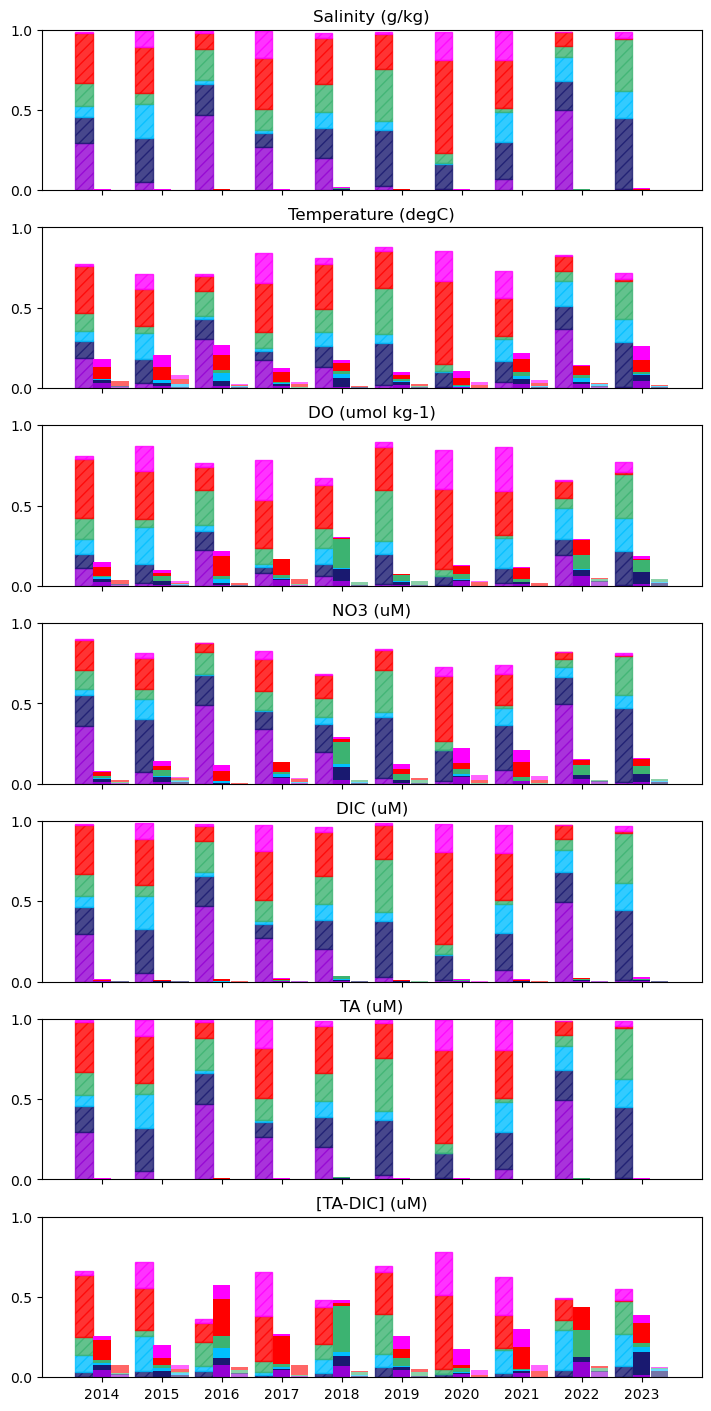

In [60]:
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[7,2*7])
gs = GridSpec(7, 1, figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])
ax7 = fig.add_subplot(gs[6])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])
three_bar(df,'Salinity (g/kg)',ax1)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])
three_bar(df,'Temperature (degC)',ax2)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])
three_bar(df,'DO (umol kg-1)',ax3)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1],])
three_bar(df,'NO3 (uM)',ax4)

# DIC
df = pd.concat([math_all14[['year','section','DICP','DICQ','DICX']][:-1],math_all15[['year','section','DICP','DICQ','DICX']][:-1],
    math_all16[['year','section','DICP','DICQ','DICX']][:-1],math_all17[['year','section','DICP','DICQ','DICX']][:-1],
    math_all18[['year','section','DICP','DICQ','DICX']][:-1],math_all19[['year','section','DICP','DICQ','DICX']][:-1],
    math_all20[['year','section','DICP','DICQ','DICX']][:-1],math_all21[['year','section','DICP','DICQ','DICX']][:-1],
    math_all22[['year','section','DICP','DICQ','DICX']][:-1],math_all23[['year','section','DICP','DICQ','DICX']][:-1],])
three_bar(df,'DIC (uM)',ax5)

# TA
df = pd.concat([math_all14[['year','section','TAP','TAQ','TAX']][:-1],math_all15[['year','section','TAP','TAQ','TAX']][:-1],
    math_all16[['year','section','TAP','TAQ','TAX']][:-1],math_all17[['year','section','TAP','TAQ','TAX']][:-1],
    math_all18[['year','section','TAP','TAQ','TAX']][:-1],math_all19[['year','section','TAP','TAQ','TAX']][:-1],
    math_all20[['year','section','TAP','TAQ','TAX']][:-1],math_all21[['year','section','TAP','TAQ','TAX']][:-1],
    math_all22[['year','section','TAP','TAQ','TAX']][:-1],math_all23[['year','section','TAP','TAQ','TAX']][:-1]])
three_bar(df,'TA (uM)',ax6)

# TA-DIC
df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])
three_bar(df,'[TA-DIC] (uM)',ax7)

ax7.set_xticklabels(np.arange(2014,2024,1));


# # # build legend handles    
# legend_handles = []
# regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
# colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','magenta']
# for i in range(len(regions)):
#     legend_handles.append(mlines.Line2D([], [], 
#                           marker='s', linestyle='None',markersize=7,
#                           markeredgecolor=colours[i], markerfacecolor=colours[i],
#                           label=regions[i]))
# # Add a figure-wide legend below the subplots
# ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

### numbers

In [71]:
# SALT

df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({})".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.004 (0.003), Q mean = 0.073 (0.072), X mean = 0.001 (0.001), mean total = 0.077 (0.072)
south: P mean = 0.001 (0.001), Q mean = 0.249 (0.152), X mean = 0.0 (0.0), mean total = 0.25 (0.151)
cuc: P mean = 0.001 (0.001), Q mean = 0.19 (0.177), X mean = 0.0 (0.0), mean total = 0.191 (0.177)
off_s: P mean = 0.001 (0.001), Q mean = 0.098 (0.072), X mean = 0.0 (0.0), mean total = 0.099 (0.072)
north: P mean = 0.003 (0.001), Q mean = 0.152 (0.1), X mean = 0.0 (0.0), mean total = 0.155 (0.101)
off_d: P mean = 0.001 (0.002), Q mean = 0.226 (0.096), X mean = 0.0 (0.0), mean total = 0.227 (0.096)
total P mean = 0.0102 (0.004), Q mean = 0.9882, (0.004)


In [74]:
# TEMP

df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({})".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.042 (0.026), Q mean = 0.075 (0.073), X mean = 0.007 (0.008), mean total = 0.124 (0.084)
south: P mean = 0.064 (0.019), Q mean = 0.23 (0.134), X mean = 0.015 (0.011), mean total = 0.31 (0.135)
cuc: P mean = 0.02 (0.012), Q mean = 0.127 (0.124), X mean = 0.003 (0.003), mean total = 0.15 (0.128)
off_s: P mean = 0.015 (0.013), Q mean = 0.085 (0.059), X mean = 0.005 (0.005), mean total = 0.105 (0.065)
north: P mean = 0.013 (0.008), Q mean = 0.119 (0.083), X mean = 0.002 (0.002), mean total = 0.134 (0.086)
off_d: P mean = 0.024 (0.014), Q mean = 0.148 (0.065), X mean = 0.005 (0.003), mean total = 0.177 (0.074)
total P mean = 0.1791 (0.0578), Q mean = 0.7844, (0.0615)


In [75]:
# DO

df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({})".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.012 (0.012), Q mean = 0.111 (0.102), X mean = 0.001 (0.002), mean total = 0.124 (0.1)
south: P mean = 0.052 (0.043), Q mean = 0.254 (0.131), X mean = 0.012 (0.011), mean total = 0.318 (0.143)
cuc: P mean = 0.023 (0.017), Q mean = 0.073 (0.076), X mean = 0.004 (0.007), mean total = 0.1 (0.09)
off_s: P mean = 0.007 (0.006), Q mean = 0.113 (0.08), X mean = 0.001 (0.002), mean total = 0.121 (0.079)
north: P mean = 0.052 (0.05), Q mean = 0.134 (0.098), X mean = 0.008 (0.007), mean total = 0.194 (0.12)
off_d: P mean = 0.028 (0.025), Q mean = 0.109 (0.052), X mean = 0.006 (0.006), mean total = 0.143 (0.072)
total P mean = 0.1735 (0.0736), Q mean = 0.7936, (0.077)


In [76]:
# NO3

df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({})".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))


fresh: P mean = 0.029 (0.029), Q mean = 0.022 (0.022), X mean = 0.007 (0.011), mean total = 0.058 (0.057)
south: P mean = 0.044 (0.022), Q mean = 0.156 (0.106), X mean = 0.011 (0.008), mean total = 0.21 (0.117)
cuc: P mean = 0.019 (0.014), Q mean = 0.211 (0.185), X mean = 0.002 (0.004), mean total = 0.232 (0.189)
off_s: P mean = 0.008 (0.007), Q mean = 0.051 (0.04), X mean = 0.002 (0.003), mean total = 0.061 (0.04)
north: P mean = 0.039 (0.036), Q mean = 0.118 (0.076), X mean = 0.006 (0.006), mean total = 0.162 (0.091)
off_d: P mean = 0.024 (0.023), Q mean = 0.247 (0.106), X mean = 0.005 (0.004), mean total = 0.276 (0.117)
total P mean = 0.1637 (0.0589), Q mean = 0.8039, (0.0646)


In [77]:
# TA

df = pd.concat([math_all14[['year','section','TAP','TAQ','TAX']][:-1],math_all15[['year','section','TAP','TAQ','TAX']][:-1],
    math_all16[['year','section','TAP','TAQ','TAX']][:-1],math_all17[['year','section','TAP','TAQ','TAX']][:-1],
    math_all18[['year','section','TAP','TAQ','TAX']][:-1],math_all19[['year','section','TAP','TAQ','TAX']][:-1],
    math_all20[['year','section','TAP','TAQ','TAX']][:-1],math_all21[['year','section','TAP','TAQ','TAX']][:-1],
    math_all22[['year','section','TAP','TAQ','TAX']][:-1],math_all23[['year','section','TAP','TAQ','TAX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({})".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.002 (0.002), Q mean = 0.075 (0.074), X mean = 0.0 (0.0), mean total = 0.078 (0.074)
south: P mean = 0.001 (0.001), Q mean = 0.249 (0.152), X mean = 0.0 (0.0), mean total = 0.25 (0.152)
cuc: P mean = 0.001 (0.001), Q mean = 0.189 (0.177), X mean = 0.0 (0.0), mean total = 0.191 (0.178)
off_s: P mean = 0.0 (0.0), Q mean = 0.098 (0.072), X mean = 0.0 (0.0), mean total = 0.099 (0.072)
north: P mean = 0.002 (0.001), Q mean = 0.152 (0.101), X mean = 0.0 (0.0), mean total = 0.155 (0.101)
off_d: P mean = 0.001 (0.002), Q mean = 0.225 (0.097), X mean = 0.0 (0.0), mean total = 0.227 (0.096)
total P mean = 0.0083 (0.0027), Q mean = 0.9904, (0.0027)


In [78]:
# DIC

df = pd.concat([math_all14[['year','section','DICP','DICQ','DICX']][:-1],math_all15[['year','section','DICP','DICQ','DICX']][:-1],
    math_all16[['year','section','DICP','DICQ','DICX']][:-1],math_all17[['year','section','DICP','DICQ','DICX']][:-1],
    math_all18[['year','section','DICP','DICQ','DICX']][:-1],math_all19[['year','section','DICP','DICQ','DICX']][:-1],
    math_all20[['year','section','DICP','DICQ','DICX']][:-1],math_all21[['year','section','DICP','DICQ','DICX']][:-1],
    math_all22[['year','section','DICP','DICQ','DICX']][:-1],math_all23[['year','section','DICP','DICQ','DICX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({})".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.004 (0.003), Q mean = 0.071 (0.07), X mean = 0.001 (0.001), mean total = 0.075 (0.072)
south: P mean = 0.004 (0.003), Q mean = 0.243 (0.15), X mean = 0.001 (0.001), mean total = 0.249 (0.149)
cuc: P mean = 0.002 (0.002), Q mean = 0.191 (0.177), X mean = 0.0 (0.001), mean total = 0.193 (0.178)
off_s: P mean = 0.001 (0.001), Q mean = 0.095 (0.07), X mean = 0.0 (0.0), mean total = 0.096 (0.07)
north: P mean = 0.005 (0.005), Q mean = 0.15 (0.099), X mean = 0.001 (0.001), mean total = 0.156 (0.1)
off_d: P mean = 0.003 (0.003), Q mean = 0.227 (0.097), X mean = 0.001 (0.0), mean total = 0.23 (0.098)
total P mean = 0.0192 (0.008), Q mean = 0.9773, (0.0081)


In [79]:
# TA-DIC

df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({})".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.056 (0.04), Q mean = 0.115 (0.104), X mean = 0.011 (0.014), mean total = 0.182 (0.136)
south: P mean = 0.107 (0.066), Q mean = 0.234 (0.124), X mean = 0.022 (0.019), mean total = 0.364 (0.124)
cuc: P mean = 0.044 (0.028), Q mean = 0.002 (0.002), X mean = 0.008 (0.011), mean total = 0.054 (0.039)
off_s: P mean = 0.018 (0.017), Q mean = 0.113 (0.082), X mean = 0.004 (0.005), mean total = 0.135 (0.083)
north: P mean = 0.069 (0.084), Q mean = 0.102 (0.074), X mean = 0.01 (0.009), mean total = 0.181 (0.12)
off_d: P mean = 0.039 (0.039), Q mean = 0.036 (0.018), X mean = 0.008 (0.011), mean total = 0.083 (0.062)
total P mean = 0.334 (0.1232), Q mean = 0.602, (0.1213)


/tmp/ipykernel_197590/819159033.py:161: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


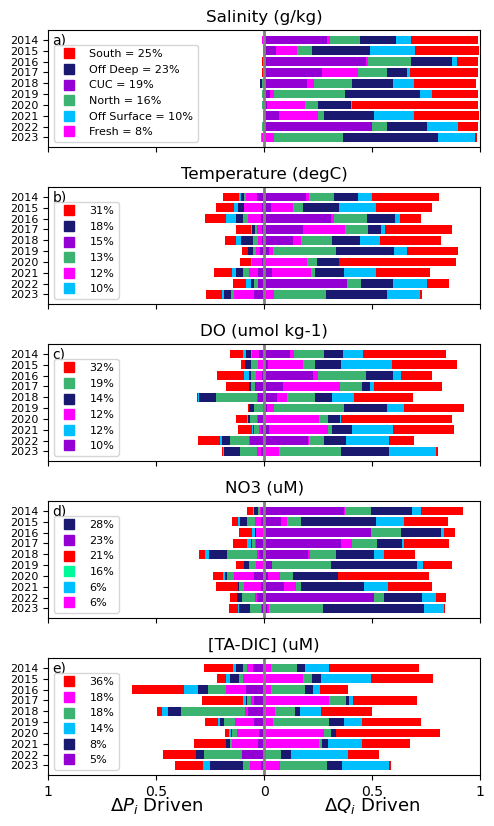

In [85]:
# with percentages included in the figure 

# Plotting
fig = plt.figure(constrained_layout=True, figsize=[5,8])
gs = GridSpec(5, 1, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[3,0])
ax9 = fig.add_subplot(gs[4,0])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])
combined_stacked_bar(df,'Salinity (g/kg)',ax1,False)
   
df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['South = {}%'.format(perc[4]), 'Off Deep = {}%'.format(perc[1]), 'CUC = {}%'.format(perc[0]), 'North = {}%'.format(perc[3]),
           'Off Surface = {}%'.format(perc[2]), 'Fresh = {}%'.format(perc[5])]
colours = ['red','midnightblue','darkviolet','mediumseagreen','deepskyblue','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])
combined_stacked_bar(df,'Temperature (degC)',ax3,False)

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[1]), '{}%'.format(perc[0]),  '{}%'.format(perc[3]),
                   '{}%'.format(perc[5]),  '{}%'.format(perc[2])]
colours = ['red','midnightblue','darkviolet','mediumseagreen','magenta','deepskyblue']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax3.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])
combined_stacked_bar(df,'DO (umol kg-1)',ax5,False)

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[3]), '{}%'.format(perc[1]), '{}%'.format(perc[5]),
                   '{}%'.format(perc[2]),  '{}%'.format(perc[0])]
colours = ['red','mediumseagreen','midnightblue','magenta','deepskyblue','darkviolet']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax5.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1]])
combined_stacked_bar(df,'NO3 (uM)',ax7,False)

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[1]), '{}%'.format(perc[0]), '{}%'.format(perc[4]),
                   '{}%'.format(perc[3]), '{}%'.format(perc[2]), '{}%'.format(perc[5])]
colours = ['midnightblue','darkviolet','red','mediumspringgreen','deepskyblue','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax7.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# TA-DIC
df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])
combined_stacked_bar(df,'[TA-DIC] (uM)',ax9,False)

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[5]), '{}%'.format(perc[3]), '{}%'.format(perc[2]),
                   '{}%'.format(perc[1]),  '{}%'.format(perc[0])]
colours = ['red','magenta','mediumseagreen','deepskyblue','midnightblue','darkviolet']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax9.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

ax9.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=10)
ax3.text(.01, .85, 'b)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=10)
ax5.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=10)
ax7.text(.01, .85, 'd)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=10)
ax9.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=10)

ax9.text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)
ax9.text(.75, -0.35, r'$\Delta Q_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)


# fig.legend(handles=legend_handles, loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.001), frameon=True,fontsize=9)
plt.savefig("/data1/bbeutel/LO_user/ariane/figures/attribution_flux.pdf", bbox_inches='tight')